# Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.linear_model import LinearRegression

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder

# Data

In [2]:
train_path = 'https://raw.githubusercontent.com/ccollado7/kaggle-tps-jan2022/main/data/raw/train.csv'
test_path = 'https://raw.githubusercontent.com/ccollado7/kaggle-tps-jan2022/main/data/raw/test.csv'

In [3]:
train = pd.read_csv(train_path)
train['date'] = pd.to_datetime(train['date'])
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['week'] = train['date'].dt.week
train['day_month'] = train['date'].dt.day
train['day_year'] = train['date'].dt.dayofyear 
train['day_week'] = train['date'].dt.dayofweek 
train['weekend']=(train['day_week']>5).astype(int)
train['friday']=(train['day_week']==4).astype(int)
train['wednesday']=(train['day_week']==2).astype(int)

countrys = train['country'].unique()
stores = train['store'].unique()
products = train['product'].unique()

In [4]:
test = pd.read_csv(test_path)
test['date'] = pd.to_datetime(test['date'])
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['week'] = test['date'].dt.week
test['day_month'] = test['date'].dt.day
test['day_year'] = test['date'].dt.dayofyear 
test['day_week'] = test['date'].dt.dayofweek
test['weekend']=(test['day_week']>5).astype(int)
test['friday']=(test['day_week']==4).astype(int)
test['wednesday']=(test['day_week']==2).astype(int)

test['num_sold'] = 0

## Functions

https://www.kaggle.com/learn/time-series

In [5]:
# funciones para modelos hibridos
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

def fit(self, X_1, X_2, y):
    name_column=y.columns.to_list()
    y1 = y.copy()  # the target
    yx=y1.reset_index('date')
    
    #yx[name_column[0]]=[ np.mean(yx[name_column[0]]) if i >= np.percentile(yx[name_column[0]], 99) or i <= np.percentile(yx[name_column[0]] , 1) else i for i in yx[name_column[0]]]
    yx[name_column[0]]=[ np.mean(yx[name_column[0]]) if i >= np.percentile(yx[name_column[0]], 99) else i for i in yx[name_column[0]]]   
    y1=yx.set_index('date')
    
    #ax = y.plot( alpha=0.5, title="num_sold", ylabel="y")
    #ax = y1.plot(ax=ax, linewidth=1, label="y1", color='0.5')
    
    self.model_1.fit(X_1, y1)

    y_fit = pd.DataFrame(
        self.model_1.predict(X_1),
        index=X_1.index, columns=y.columns,
    )

    y_resid = y - y_fit
    
    #plt.figure(figsize=(12,8))
    #plt.plot(y_resid)
    y_resid = y_resid.stack().squeeze() # wide to long
    
    self.model_2.fit(X_2, y_resid)

    # Save column names for predict method
    self.y_columns = y.columns
    # Save data for question checking
    self.y_fit = y_fit
    self.y_resid = y_resid

BoostedHybrid.fit = fit
    
def predict(self, X_1, X_2):
    y_pred = pd.DataFrame(
        self.model_1.predict(X_1),
        index=X_1.index, columns=self.y_columns,
    )
    y_pred = y_pred.stack().squeeze()  # wide to long
    y_pred += self.model_2.predict(X_2)
    feature_important = self.model_2.get_booster().get_score(importance_type='weight')
    #print(feature_important)
    return y_pred.unstack()  # long to wide


BoostedHybrid.predict = predict

In [6]:
#funciones para ploteo estacional, básico y períodograma
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

## My functions

In [7]:
# métrica competencia
def smape_loss(y_true, y_pred):
    """SMAPE Loss"""
    return np.abs(y_true - y_pred) / (y_true + np.abs(y_pred)) * 200

def armar_dataset(dataset, country, store, product):
    df=dataset[(dataset['country'] == country) & (train['store'] == store) & ((train['product'] == product))]
    y=df.set_index('date').pivot(values='num_sold',columns=['product'])
    df=df.set_index('date')
    return df, y

# Feature Engineering
1. Add Holidays

2. Add other dates ->  https://www.kaggle.com/ambrosm/tpsjan22-03-linear-model/notebook

3. Add Rock Festival - Sweden

4. GDP per capita ->  https://www.kaggle.com/ambrosm/tpsjan22-03-linear-model/notebook

In [8]:
holiday_path = 'https://raw.githubusercontent.com/ffelicioni/kaggle_tps_jan2022/main/src/Holidays_Finland_Norway_Sweden_2015-2019.csv'


holiday_df = pd.read_csv(holiday_path)

def agregar_holidays(df, country):
    holidays=holiday_df[holiday_df['Country']==country]
    holidays=holidays[holidays['Date']<'2019-01-01']
    holidays.rename({'Date': 'date'}, axis=1, inplace=True)
    holidays['date'] = pd.to_datetime(holidays['date'])
    
    holidays_country =holidays[['date','Name']]
    holidays_country=holidays_country.set_index('date')

    ohe = OneHotEncoder(sparse=False)
    X_holidays = pd.DataFrame(ohe.fit_transform(holidays_country),columns=sorted(holidays_country.Name.unique()),index=holidays_country.index)
    #X_holidays.set_index(holidays['date'])
    #print(X_holidays)
    
    xx=df.join(X_holidays)
    return xx.fillna(0), holidays_country.Name.unique()


def agregar_fechas(df):
    #to_datetime
    df1=df.copy()
    df=df.reset_index()
    
    # navidad 
    new_df = pd.DataFrame({f"dec{d}": (df.date.dt.month == 12) & (df.date.dt.day == d) for d in range(27, 31)}).astype(int)
    
    new_df = pd.concat([new_df, pd.DataFrame({f"may{d}": (df.date.dt.month == 5) & (df.date.dt.day == d) 
                                      for d in list(range(2, 10))}).astype(int)],axis=1)  
    
    
    if (df.country.values[0] == 'Sweden'): 
        # First Sunday of November
        sun_nov_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-11-1')),
                                         2016: pd.Timestamp(('2016-11-6')),
                                         2017: pd.Timestamp(('2017-11-5')),
                                         2018: pd.Timestamp(('2018-11-4')),
                                         2019: pd.Timestamp(('2019-11-3'))})
        new_df = pd.concat([new_df, pd.DataFrame({f"sun_nov_date{d}": (df.date - sun_nov_date == np.timedelta64(d, "D")) 
                                       for d in list(range(0, 9))}).astype(int)],axis=1)
        # June
        new_df = pd.concat([new_df,
                        pd.DataFrame({f"june{d}":
                                      (df.date.dt.month == 6) & (df.date.dt.day == d) 
                                      for d in list(range(8, 14))}).astype(int),], axis=1)
        # navidad - primeros dias enero - incluye Epiphany
        new_df = pd.concat([new_df, pd.DataFrame({f"jan{d}":
                                      (df.date.dt.month == 1) & (df.date.dt.day == d) 
                                      for d in range(2, 15)}).astype(int)], axis=1)
        
        wed_june_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-06-24')),
                                         2016: pd.Timestamp(('2016-06-29')),
                                         2017: pd.Timestamp(('2017-06-28')),
                                         2018: pd.Timestamp(('2018-06-27')),
                                         2019: pd.Timestamp(('2019-06-26'))})
        # Last Wednesday of June
        new_df = pd.concat([new_df, pd.DataFrame({f"wed_june{d}": 
                                      (df.date - wed_june_date == np.timedelta64(d, "D")) 
                                      for d in list(range(-3, 6))}).astype(int)],axis=1)

    
    if (df.country.values[0] == 'Norway'): 
        # May
        new_df = pd.concat([new_df,  pd.DataFrame({f"may{d}":
                                      (df.date.dt.month == 5) & (df.date.dt.day == d) 
                                      for d in list(range(19, 26))}).astype(int)], axis=1)
       # primeros dias enero - incluye Epiphany
        new_df = pd.concat([new_df,
                        pd.DataFrame({f"jan{d}":
                                      (df.date.dt.month == 1) & (df.date.dt.day == d) 
                                      for d in range(2, 10)}).astype(int)], axis=1)
    
    if (df.country.values[0] == 'Finland'): 
        # navidad - primeros dias enero - incluye Epiphany
        new_df = pd.concat([new_df, pd.DataFrame({f"jan{d}":
                                      (df.date.dt.month == 1) & (df.date.dt.day == d) 
                                      for d in range(2, 14)}).astype(int)], axis=1)
        
        wed_june_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-06-24')),
                                         2016: pd.Timestamp(('2016-06-29')),
                                         2017: pd.Timestamp(('2017-06-28')),
                                         2018: pd.Timestamp(('2018-06-27')),
                                         2019: pd.Timestamp(('2019-06-26'))})
        # Last Wednesday of June
        new_df = pd.concat([new_df, pd.DataFrame({f"wed_june{d}": 
                                      (df.date - wed_june_date == np.timedelta64(d, "D")) 
                                      for d in list(range(-4, 6))}).astype(int)],axis=1)
    
       
    #new_def=new_def.astype(int)
    new_df['date']=pd.to_datetime(df.date)
    new_df=new_df.set_index('date')
    df=pd.concat([df1,new_df],axis=1)
    return df, new_df.columns.to_list()

def agregar_rock_fest(df, country):
    #to_datetime
    df1=df.copy()
    df1=df1.reset_index()
    Swed_Rock_Fest  = df1.date.dt.year.map({2015: pd.Timestamp(('2015-06-6')),
                                     2016: pd.Timestamp(('2016-06-11')),
                                     2017: pd.Timestamp(('2017-06-10')),
                                     2018: pd.Timestamp(('2018-06-10')),
                                     2019: pd.Timestamp(('2019-06-8'))})
    new_df = pd.DataFrame({f"Swed_Rock_Fest{d}": (df1.date - Swed_Rock_Fest == np.timedelta64(d, "D")) & (df1.country == 'Sweden') for d in list(range(-2, 3))}).astype(int)
    new_df['date']=pd.to_datetime(df1.date)
    new_df=new_df.set_index('date')
    
    df=pd.concat([df,new_df],axis=1)
    return df, new_df.columns.to_list()

# GDP Correction
gdp_path = 'https://raw.githubusercontent.com/ffelicioni/kaggle_tps_jan2022/main/src/GDP_data_2015_to_2019_Finland_Norway_Sweden.csv'
gdp_df = pd.read_csv(gdp_path)

def get_gdp(row):
    """Return the GDP based on row.country and row.date.year"""
    gdp_exponent=1.2121103201489674
    #row=row.reset_index()
    #print(row)
    country = 'GDP_' + row.country
    #row=row.reset_index()
    year=pd.to_numeric(row.year)
    row_id=(gdp_df.loc[gdp_df['year'] == year])
    return np.asscalar(row_id[country].values[0]) ** gdp_exponent

# Hybrid Model

## Linear + XGB regressor - transformed ouput

1. GDP Correction

2. Hybrid model

3. Different seasonalities (comparing Fourier components of both Kaggle Sticker and Kaggle Mug sales) 

4. Feature Engineering

In [9]:
def entrenamiento_corregido(train,country,store,product):
    sub_train, y = armar_dataset(train, country, store, product)
    sub_train, holidays_names=agregar_holidays(sub_train,country)
    sub_train, lista_fechas=agregar_fechas(sub_train)
    #if country=='Sweden':
    #    sub_train,sweden_list=agregar_rock_fest(sub_train, 'Sweden')
        
    sub_train['gdp']=sub_train.apply(get_gdp, axis=1)
    sub_train['target']=np.log(sub_train['num_sold'] / sub_train['gdp'])
    
    df=sub_train
    df=df.reset_index()    
    yy=df.set_index('date').pivot(values='target',columns=['product'])   #transform the output using GDP of each country 
    
    N=len(sub_train)
    X_train, X_val, y_train, y_val = train_test_split(sub_train, yy, shuffle=False,train_size=N-365,test_size=365)
    
    if product=='Kaggle Sticker':   # sales does not show annual seasonality 
        dp = DeterministicProcess(
        index=y_train.index,
        constant=False,
        order=1,
        seasonal=True,               # weekly seasonality (indicators)
        drop=True,
        )
    else:
        fourier = CalendarFourier(freq="A", order=4) 
        dp = DeterministicProcess(
        index=y_train.index,
        constant=False,
        order=1,
        seasonal=True,               # weekly seasonality (indicators)
        additional_terms=[fourier],  # monthly seasonality (fourier)
        drop=True,
        )
    
    ax1 = plot_periodogram(y_train[product])
    ax1.set_title(country+'_'+store+'_'+product)
    
    X1 = dp.in_sample()
    X1_fore = dp.out_of_sample(365,forecast_index=X_val.index)
    
    
    columns_X2=list(holidays_names)+['weekend','day_year','month','wednesday']+lista_fechas
    if (country!='Norway'):
        columns_X2.remove('Epiphany')
        
    if (country=='Norway'):
        columns_X2.remove('Pentecost')
        columns_X2.remove('Whit Monday')
        
    #print(columns_X2)
    #if country=='Sweden':
    #    columns_X2=columns_X2#+sweden_list
    
    #X2= np.hstack([X_train[['day_week','day_year','day_month']]])
    #X2_fore=np.hstack([X_val[['day_week','day_year','day_month']]])
    #X2= np.hstack([X_train[['weekend','day_year','day_month']]])
    #X2_fore=np.hstack([X_val[['weekend','day_year','day_month']]])
    X2= np.hstack([X_train[columns_X2]])
    X2_fore=np.hstack([X_val[columns_X2]])
    
    model = BoostedHybrid(
        model_1=LinearRegression(fit_intercept=False),
        #model_1=Ridge(),
        #model_2=XGBRegressor(learning_rate = 0.1, max_depth = 5, n_estimators = 100),
        model_2=XGBRegressor(colsample_bytree = 0.2, learning_rate = 0.1, max_depth = 5, n_estimators = 200),
    )

    model.fit(X1, X2, y_train)
    
    y_pred = model.predict(X1, X2) 
    zz=pd.DataFrame(X_train['gdp'])
    rr=np.exp(y_pred)
    y_pred=rr[product]*zz['gdp']                   #antitransform the output using GDP of each country 
    
    y_val=np.exp(y_val)*(X_val['gdp'].values[0])

    
    y_pred_future = model.predict(X1_fore,X2_fore)     
    y_pred_future=np.exp(y_pred_future)*(X_val['gdp'].values[0])#*X_val['gdp']
   
    # plot predictions
    plt.figure(figsize=(12,8))
    ax = y.plot(**plot_params)
    ax=y_pred.plot(ax=ax, linewidth=1, legend=False,);
    ax=y_pred_future.plot(ax=ax, linewidth=1, title=country+'_'+store+'_'+product, legend=False,);
    
    smape_mean=smape_loss(np.array(y_val), np.array(y_pred_future)).mean()
    df_x=pd.DataFrame({'country': [country], 'store': [store], 'product': [product], 'smape': [smape_mean]})
    return df_x

## Example 
1. Train 2015 - 2018
2. Test 2018 

   country       store         product     smape
0  Finland  KaggleMart      Kaggle Mug  4.973143
0  Finland  KaggleMart      Kaggle Hat  5.111780
0  Finland  KaggleMart  Kaggle Sticker  5.055800
0  Finland  KaggleRama      Kaggle Mug  5.127098
0  Finland  KaggleRama      Kaggle Hat  4.936878
0  Finland  KaggleRama  Kaggle Sticker  5.240325
0   Norway  KaggleMart      Kaggle Mug  5.081227
0   Norway  KaggleMart      Kaggle Hat  5.118819
0   Norway  KaggleMart  Kaggle Sticker  5.332042
0   Norway  KaggleRama      Kaggle Mug  5.381875
0   Norway  KaggleRama      Kaggle Hat  5.149293
0   Norway  KaggleRama  Kaggle Sticker  5.540229
0   Sweden  KaggleMart      Kaggle Mug  4.883716
0   Sweden  KaggleMart      Kaggle Hat  4.775639
0   Sweden  KaggleMart  Kaggle Sticker  4.921689
0   Sweden  KaggleRama      Kaggle Mug  4.826411
0   Sweden  KaggleRama      Kaggle Hat  4.654255
0   Sweden  KaggleRama  Kaggle Sticker  4.986032
smape _ media 5.060902742299608


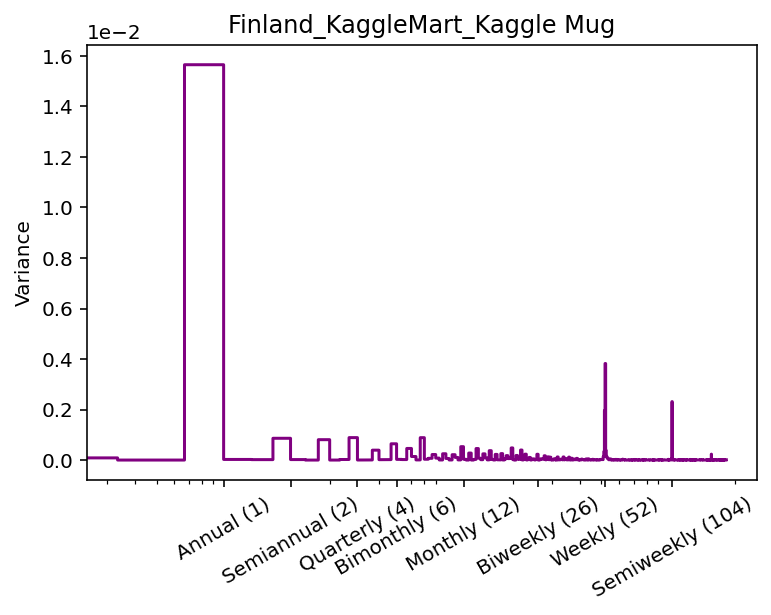

<Figure size 864x576 with 0 Axes>

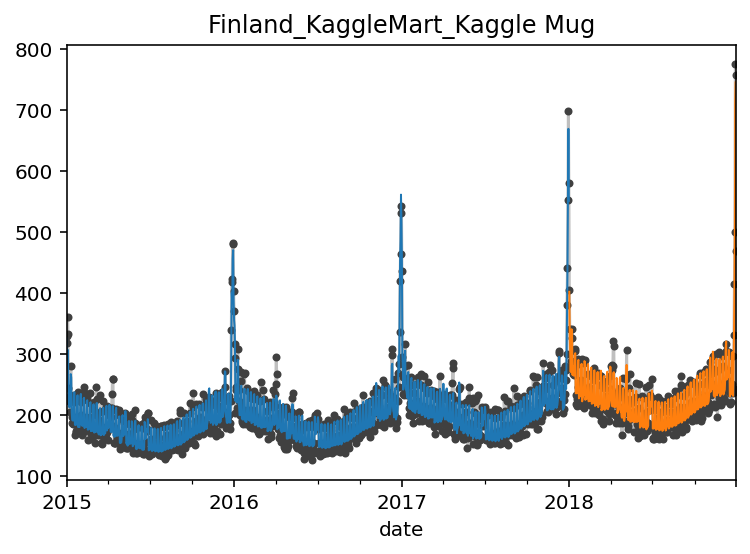

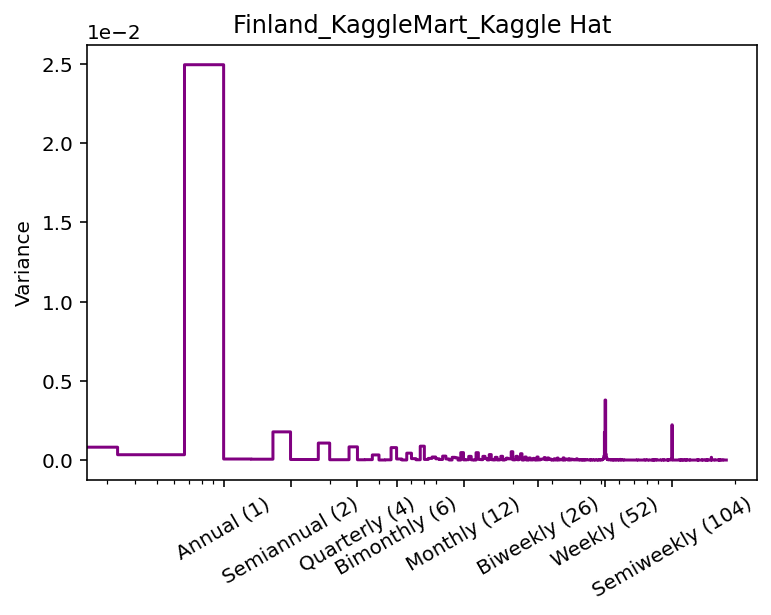

<Figure size 864x576 with 0 Axes>

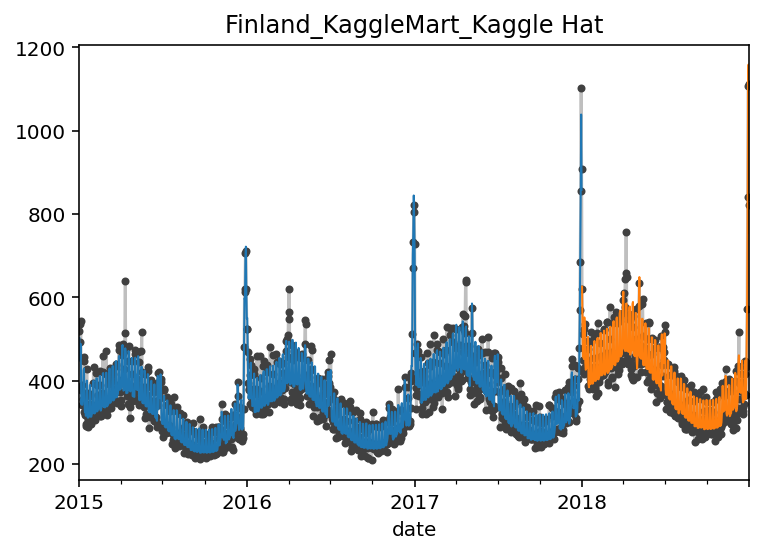

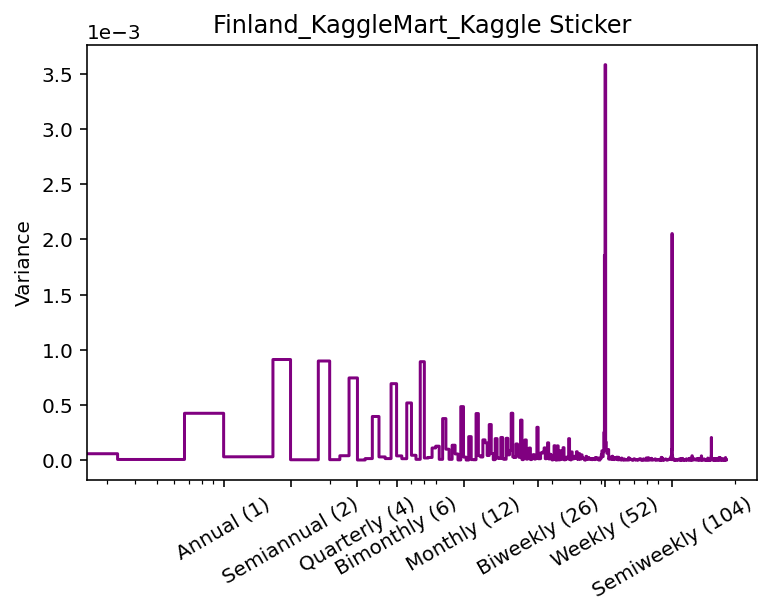

<Figure size 864x576 with 0 Axes>

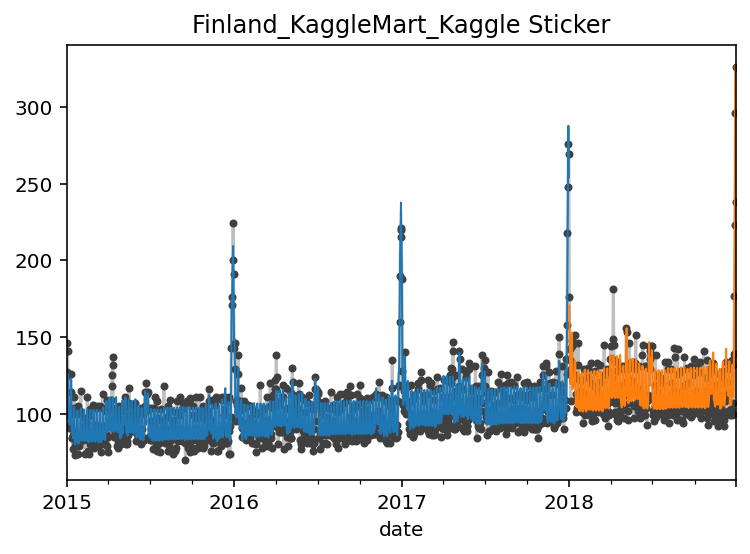

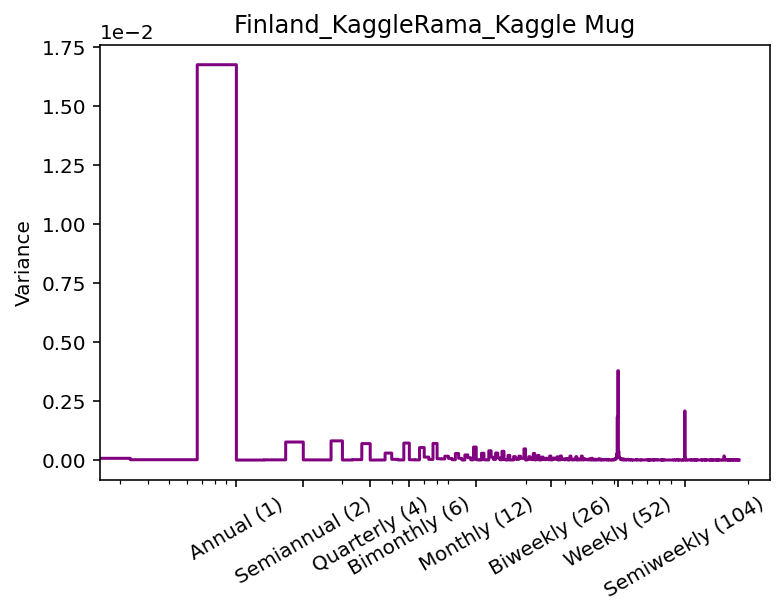

<Figure size 864x576 with 0 Axes>

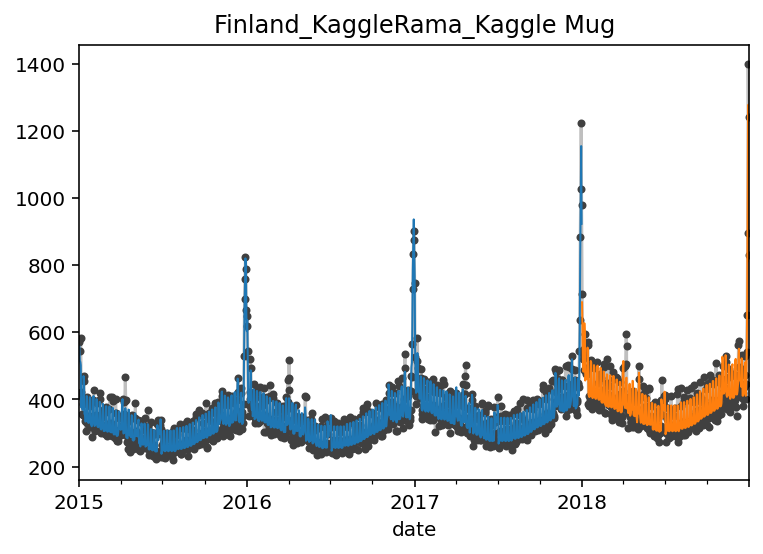

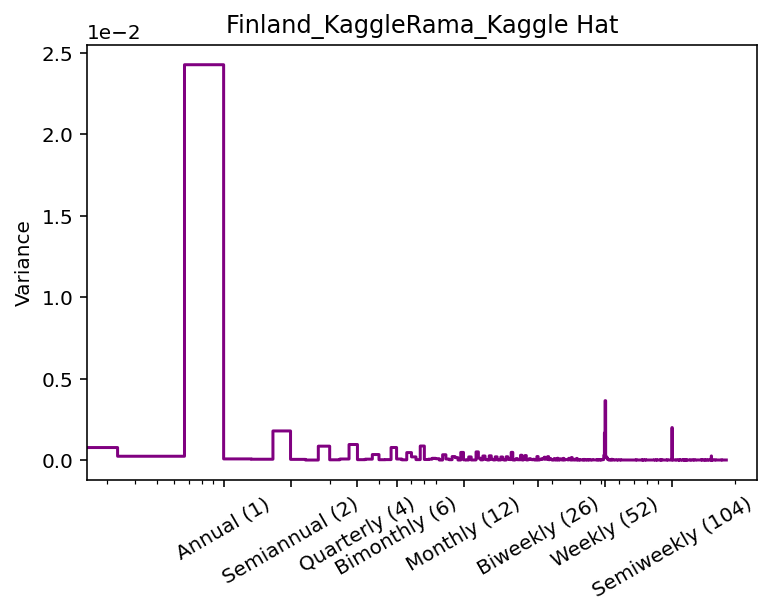

<Figure size 864x576 with 0 Axes>

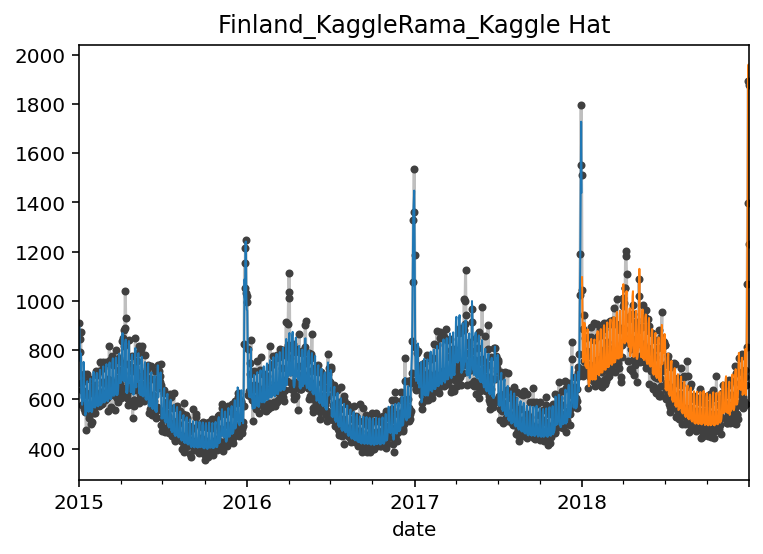

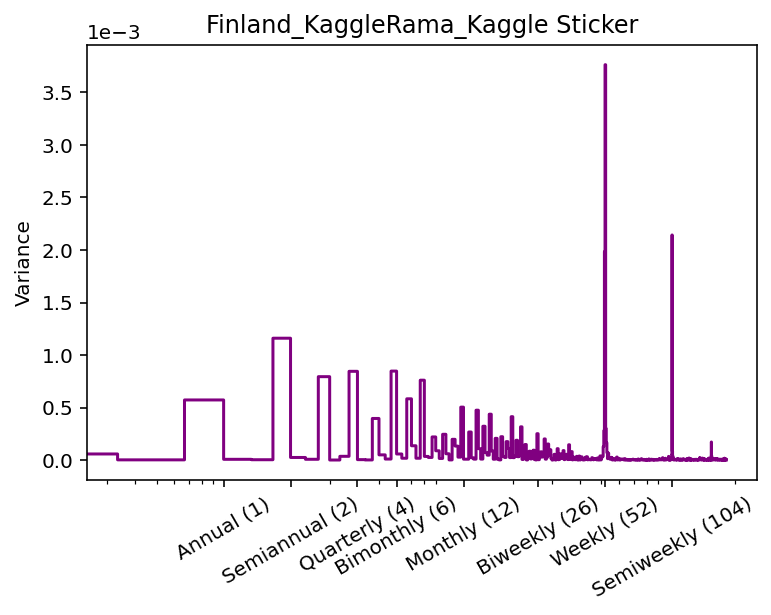

<Figure size 864x576 with 0 Axes>

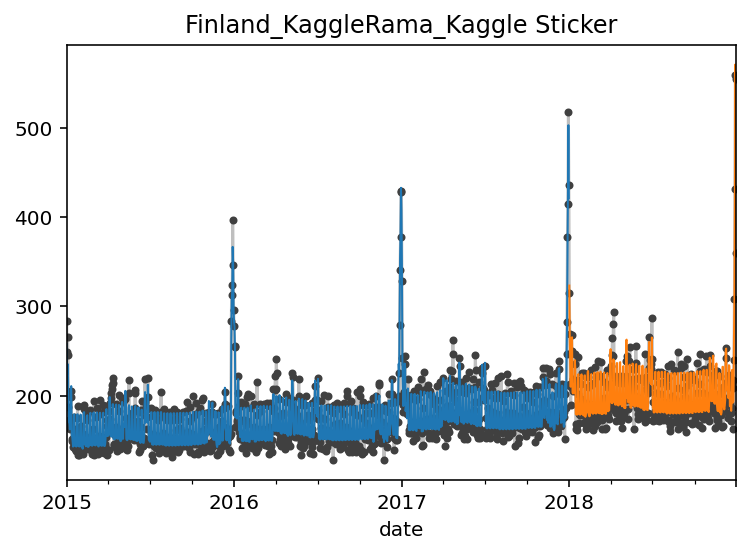

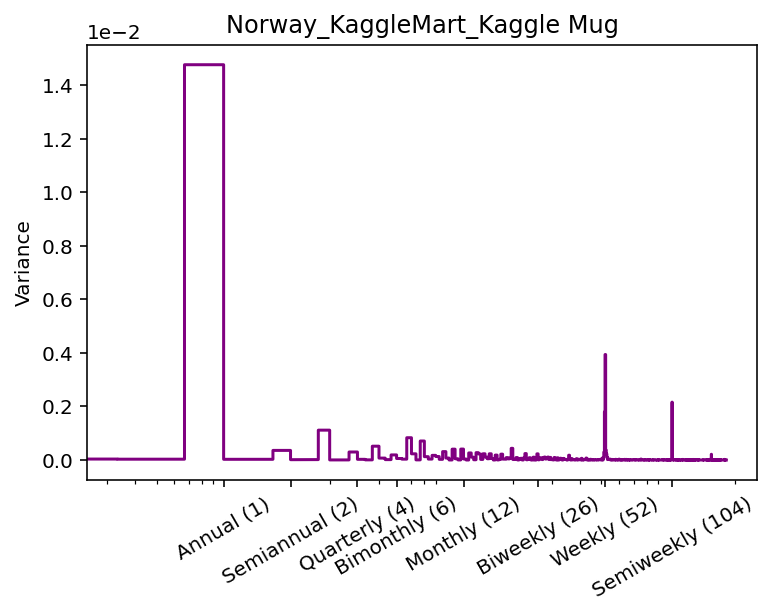

<Figure size 864x576 with 0 Axes>

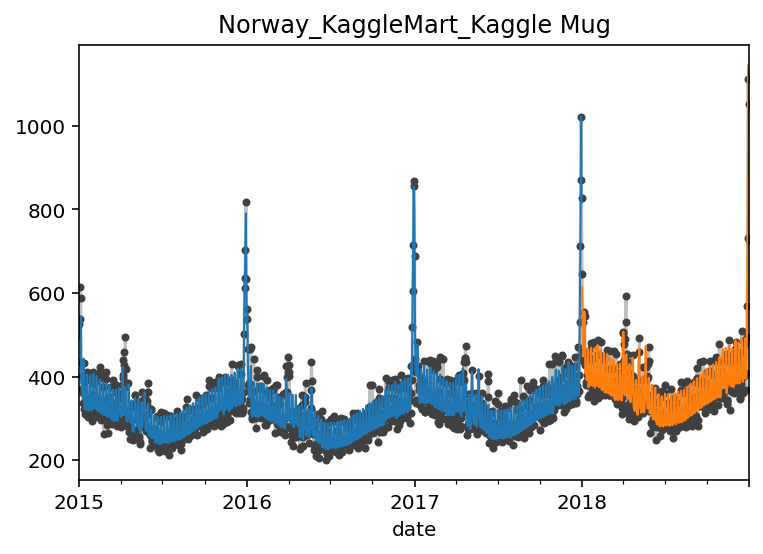

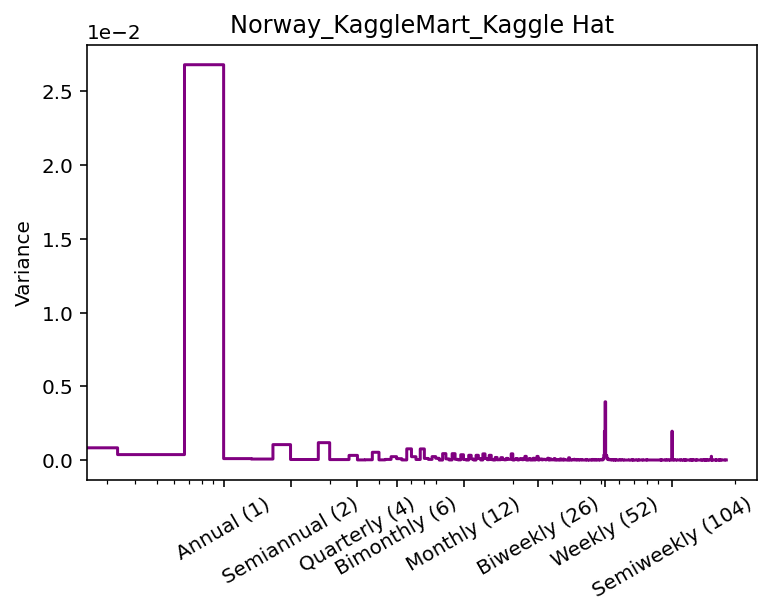

<Figure size 864x576 with 0 Axes>

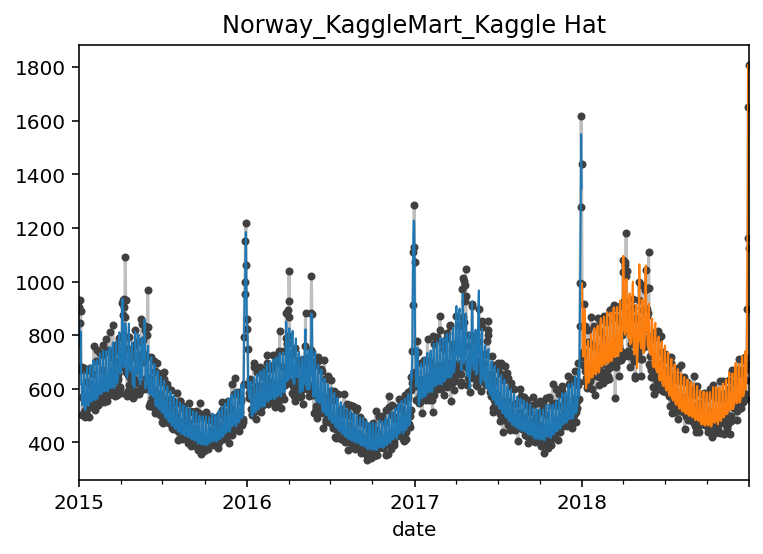

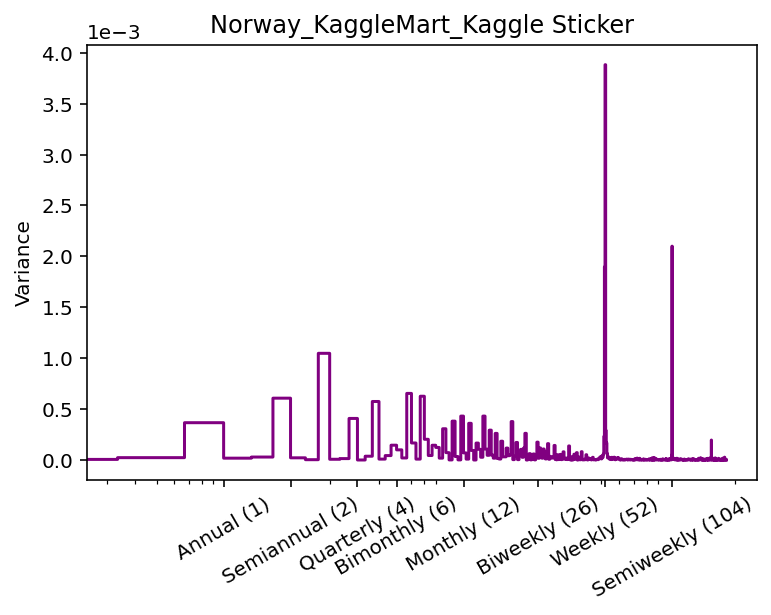

<Figure size 864x576 with 0 Axes>

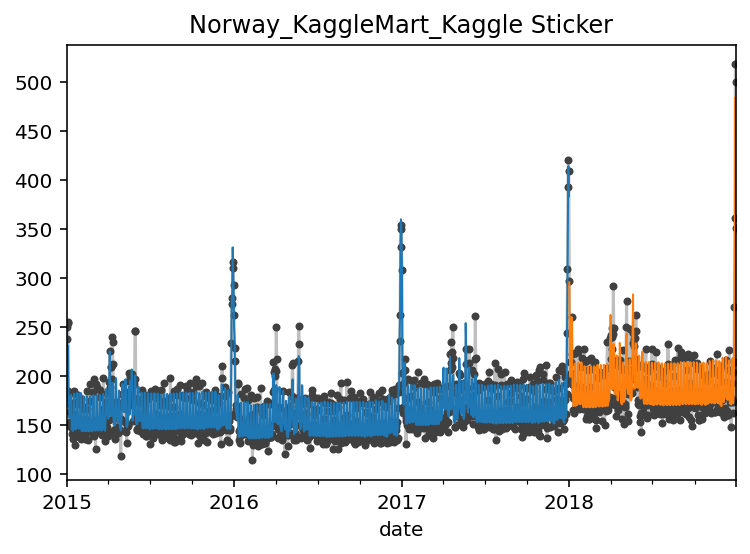

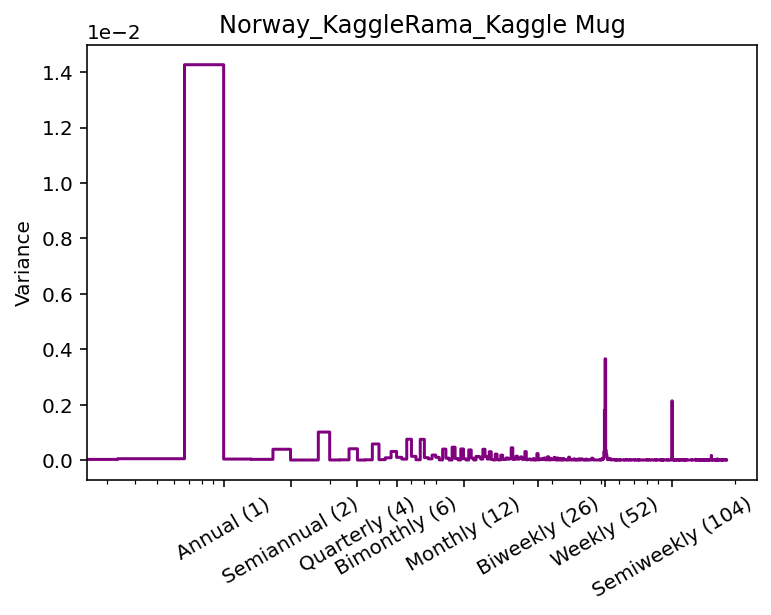

<Figure size 864x576 with 0 Axes>

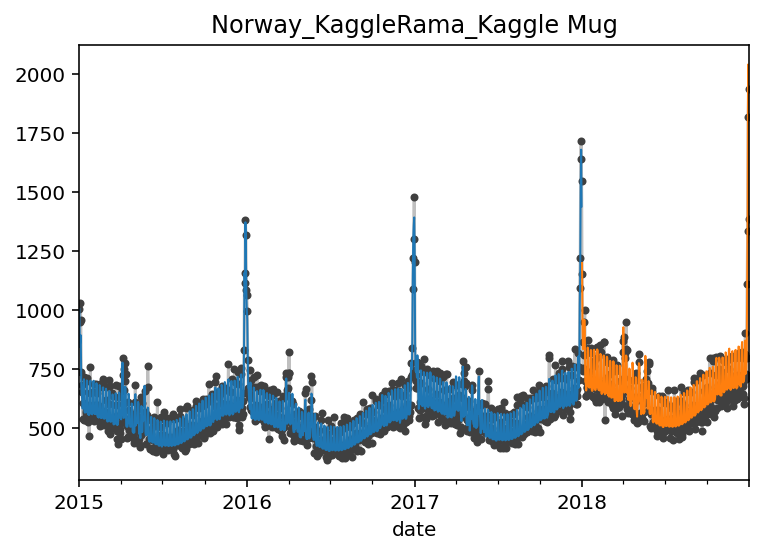

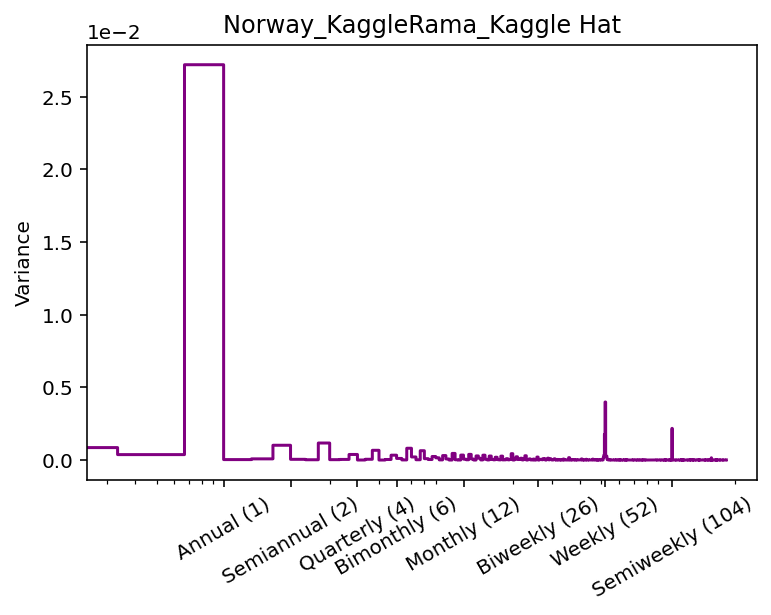

<Figure size 864x576 with 0 Axes>

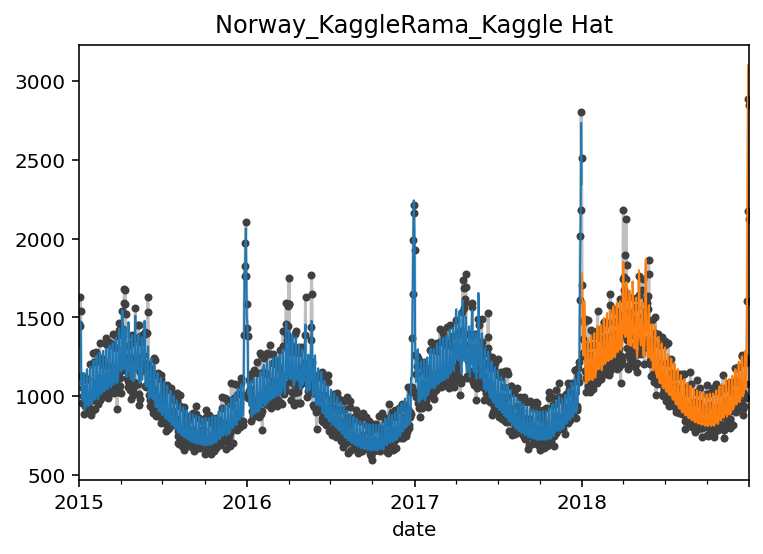

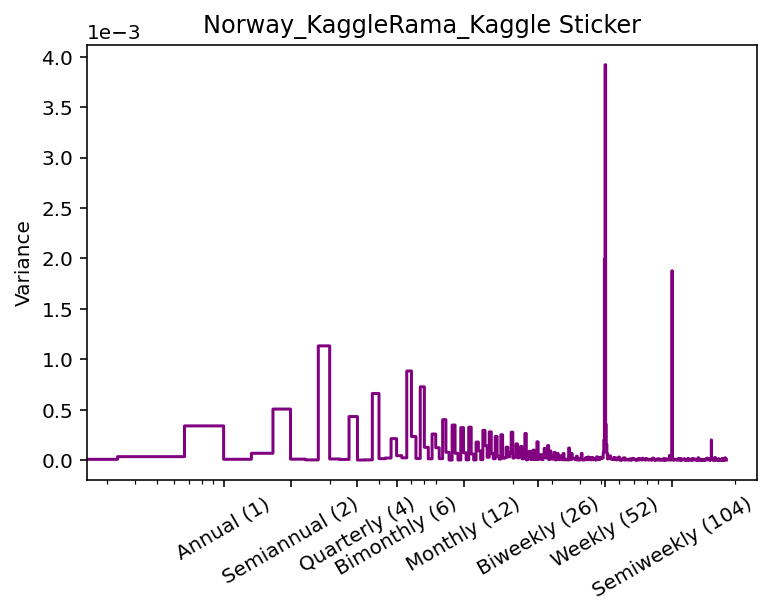

<Figure size 864x576 with 0 Axes>

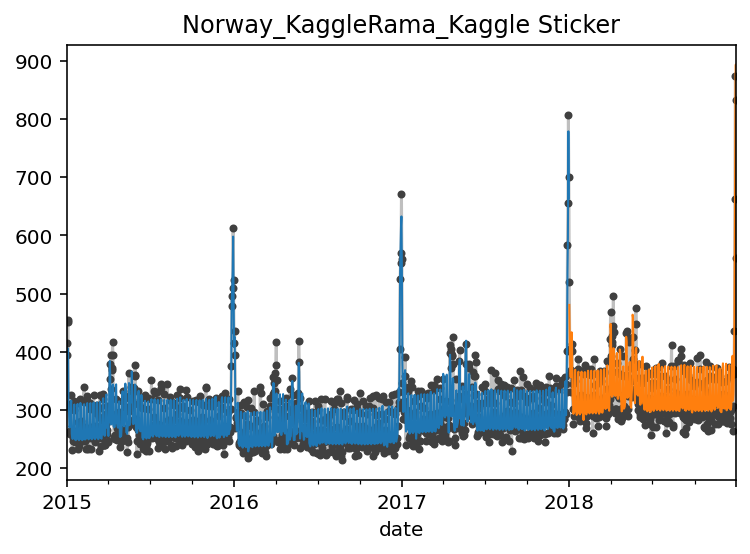

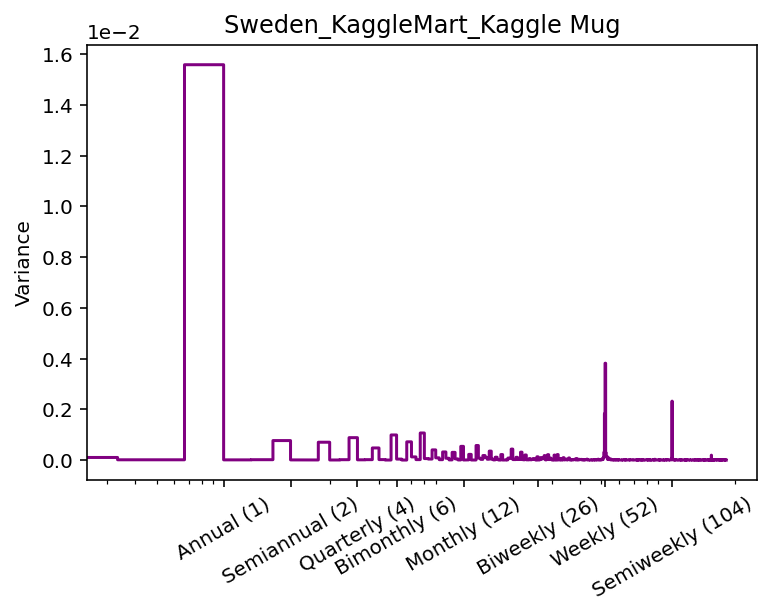

<Figure size 864x576 with 0 Axes>

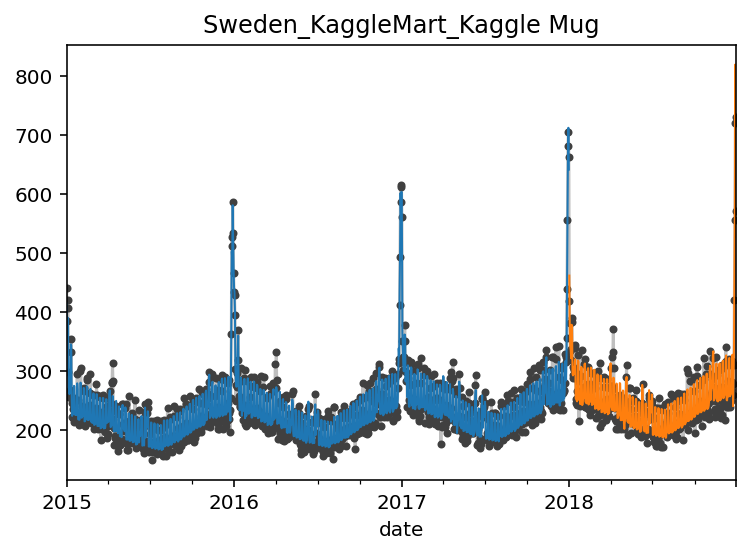

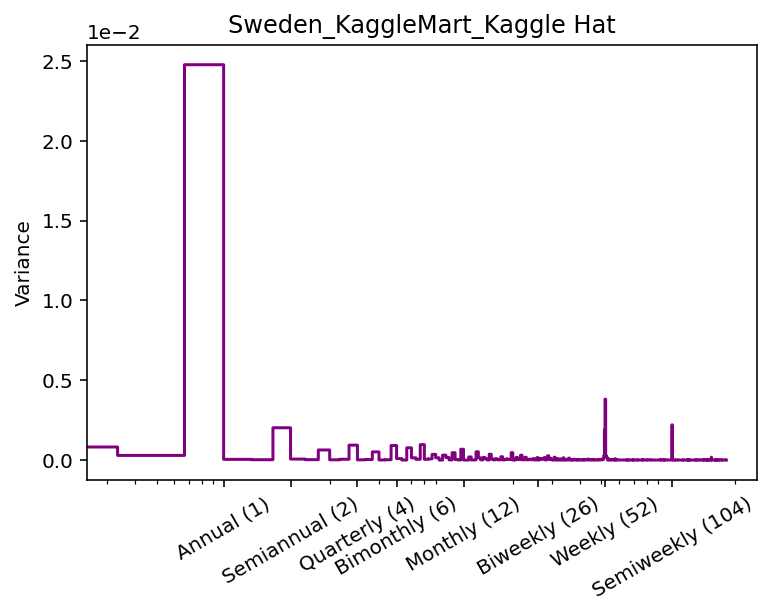

<Figure size 864x576 with 0 Axes>

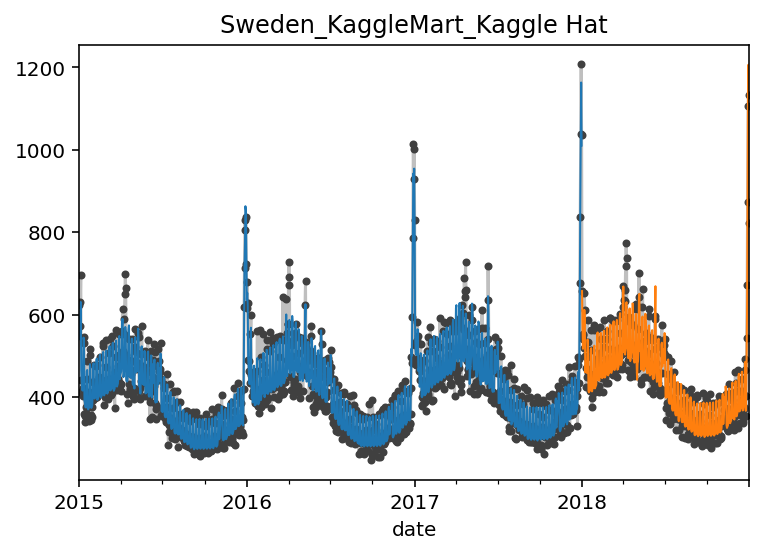

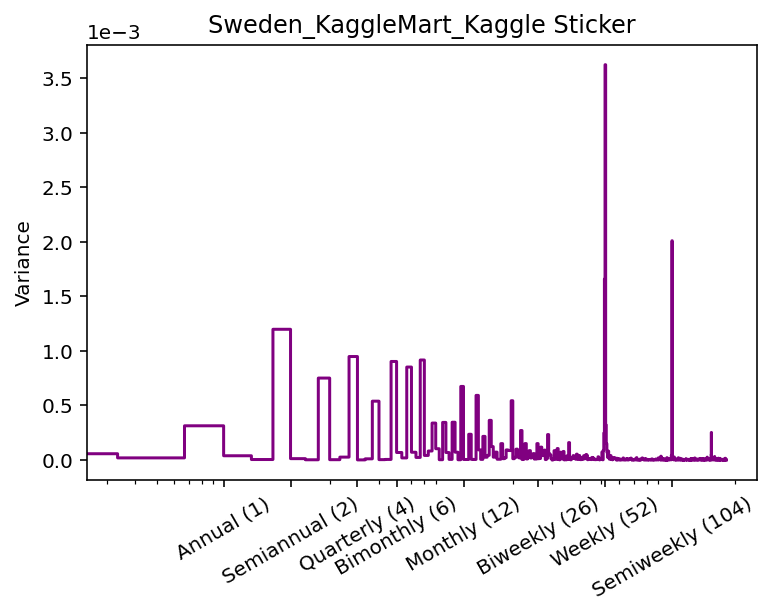

<Figure size 864x576 with 0 Axes>

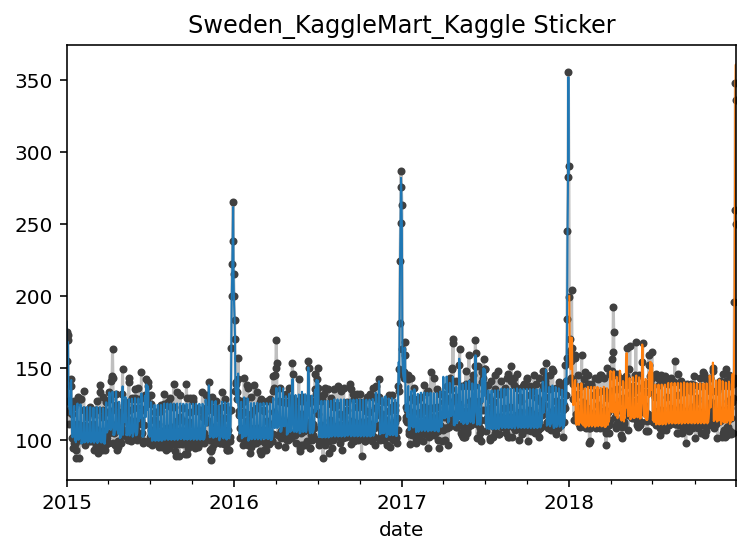

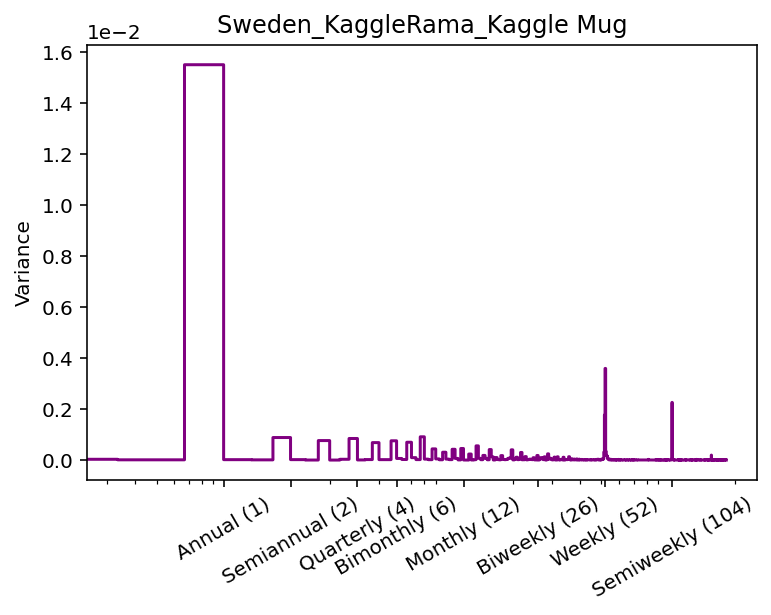

<Figure size 864x576 with 0 Axes>

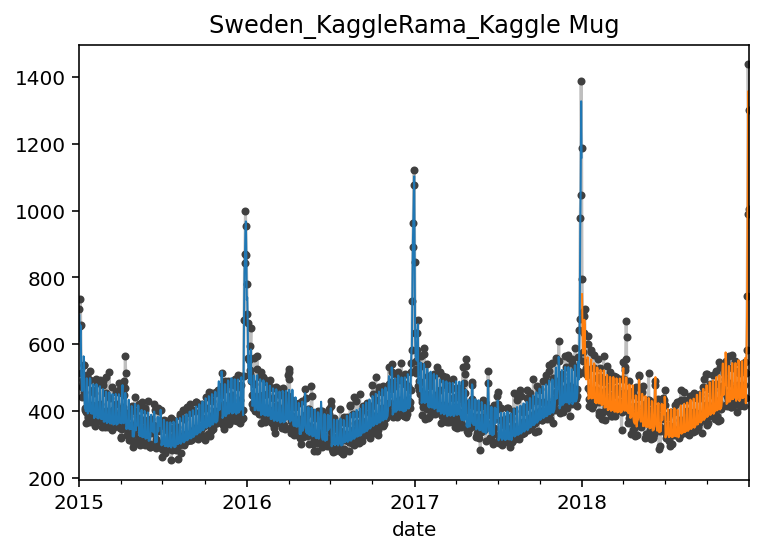

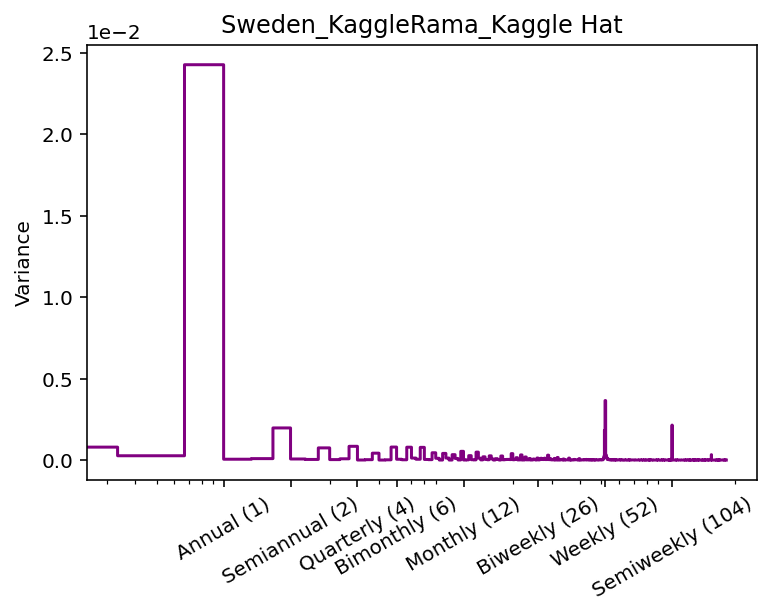

<Figure size 864x576 with 0 Axes>

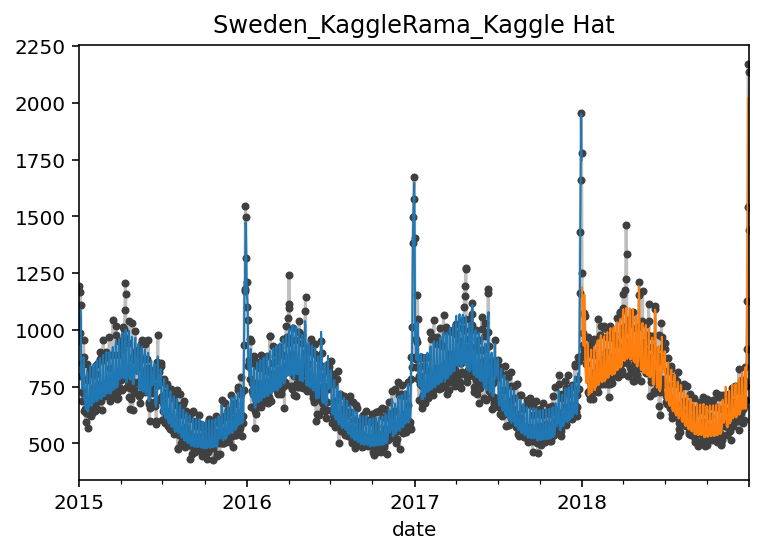

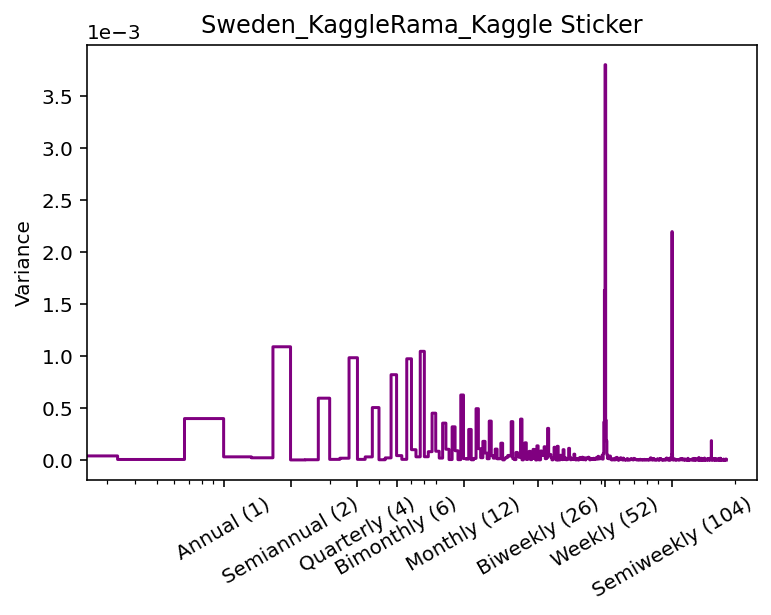

<Figure size 864x576 with 0 Axes>

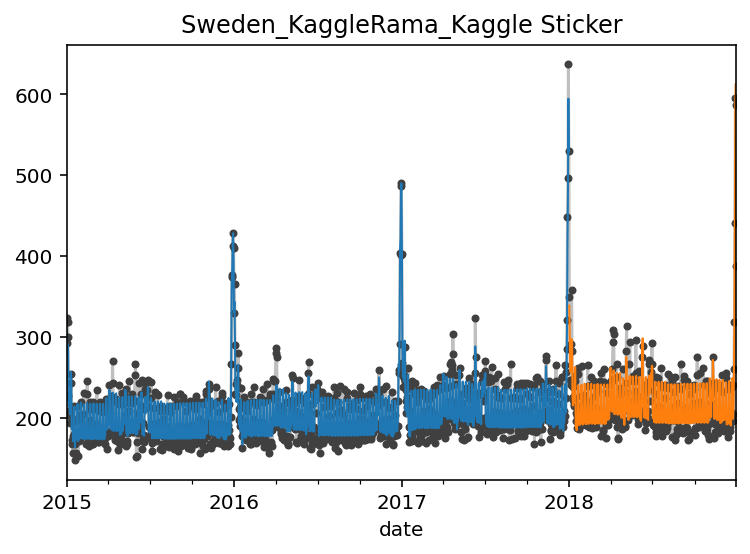

In [10]:
df_smape=pd.DataFrame(columns = ['country', 'store','product','smape'])

df_predict = pd.DataFrame(columns = ['row_id', 'num_sold'])

#loop to iterate in every combination country/store/product
for country in countrys:
    for store in stores:
        for product in products:            
            df_x=entrenamiento_corregido(train,country,store,product)
            df_smape = pd.concat([df_smape,df_x],axis=0)
            
print(df_smape)
print('smape _ media', df_smape.smape.mean())

## Kaggle submission

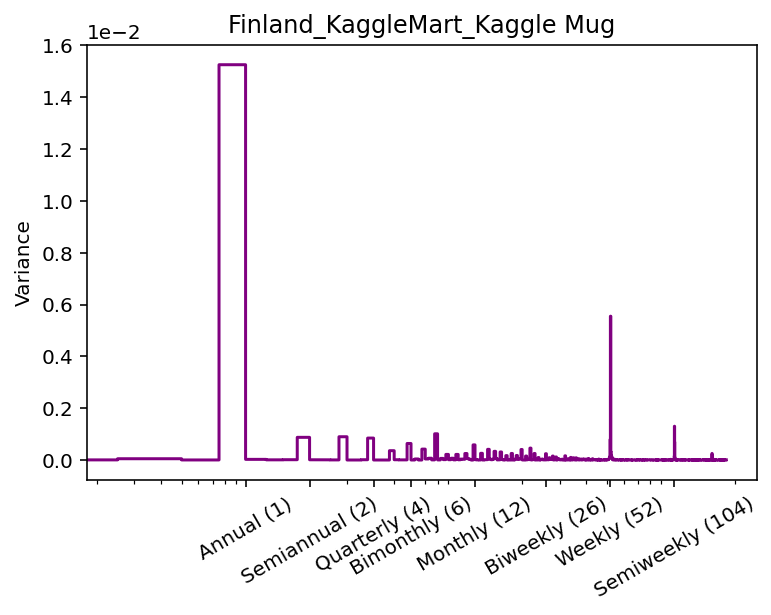

<Figure size 864x576 with 0 Axes>

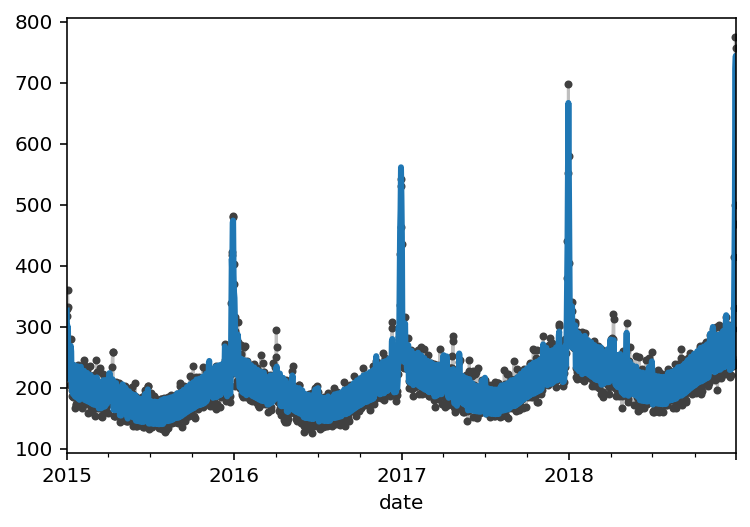

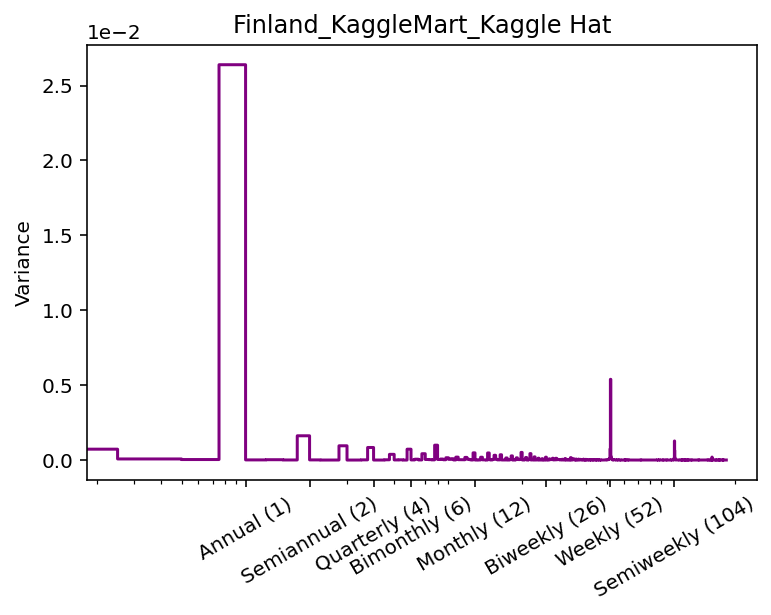

<Figure size 864x576 with 0 Axes>

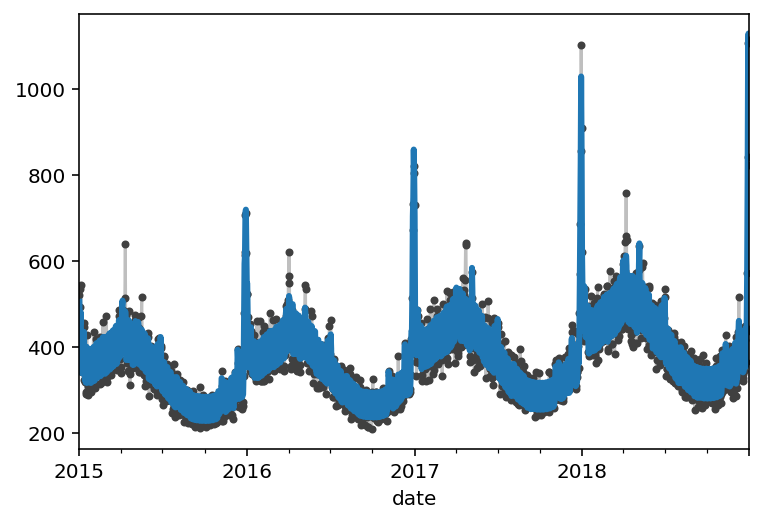

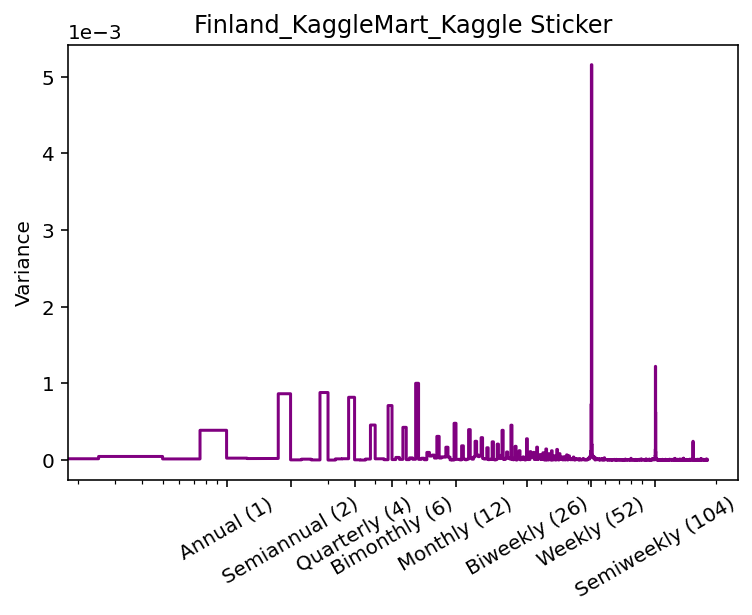

<Figure size 864x576 with 0 Axes>

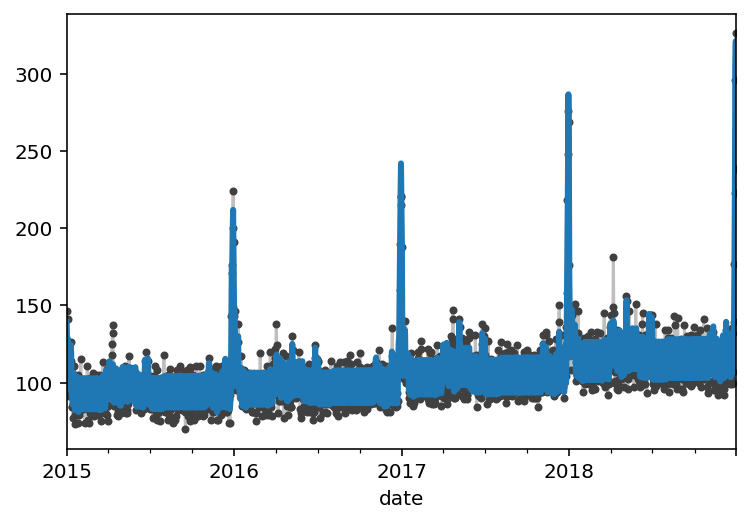

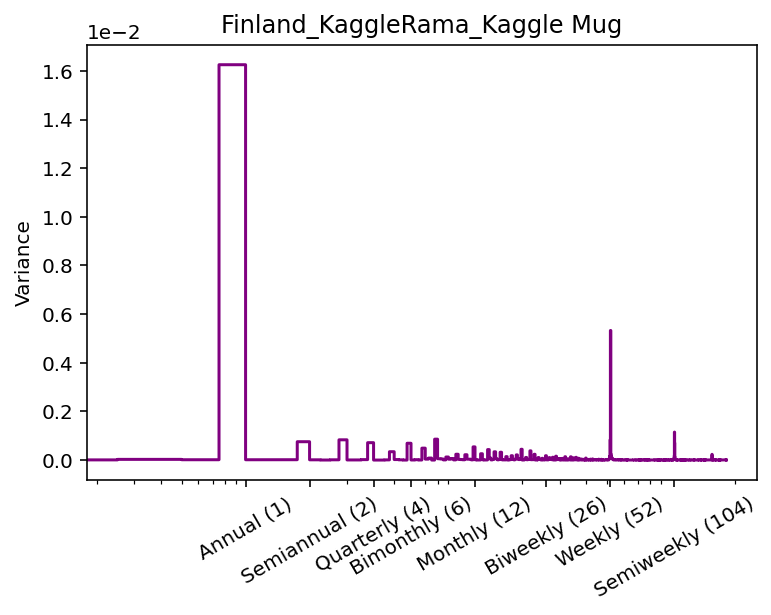

<Figure size 864x576 with 0 Axes>

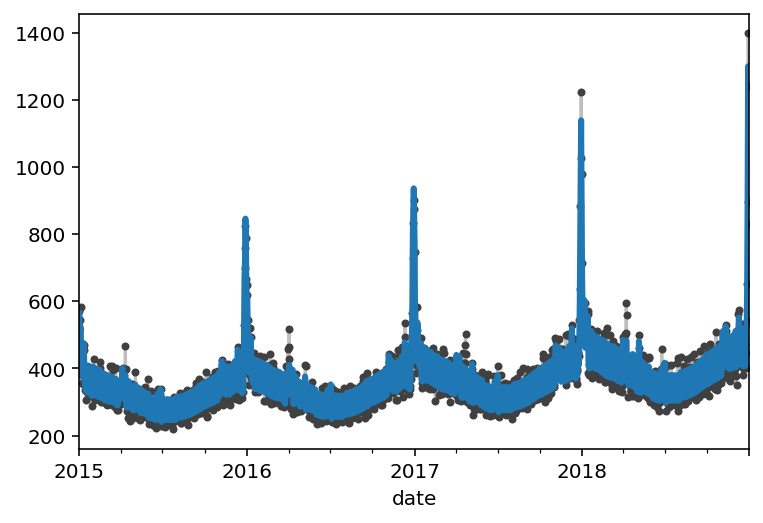

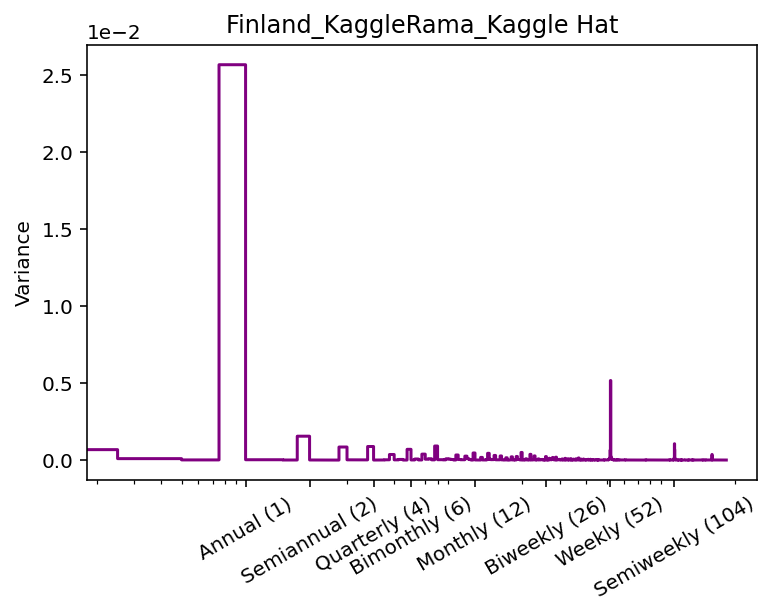

<Figure size 864x576 with 0 Axes>

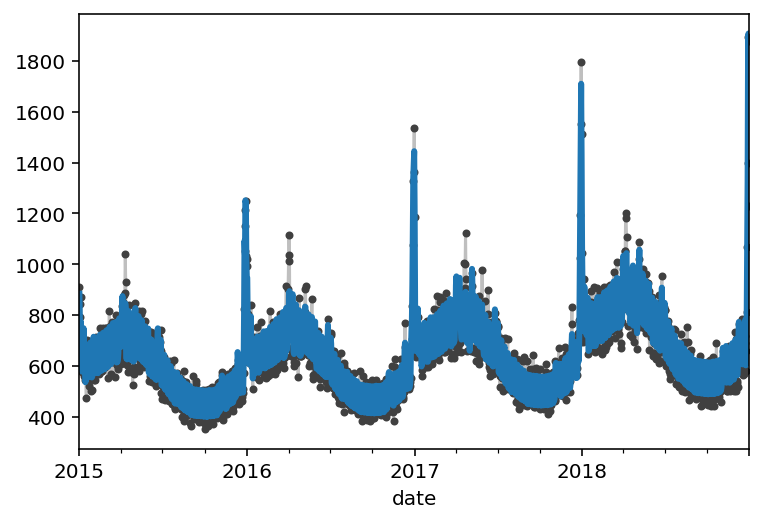

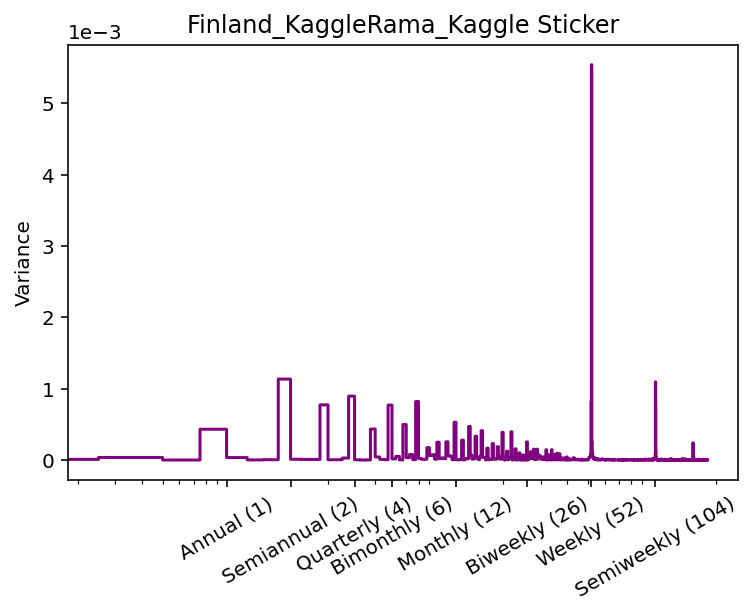

<Figure size 864x576 with 0 Axes>

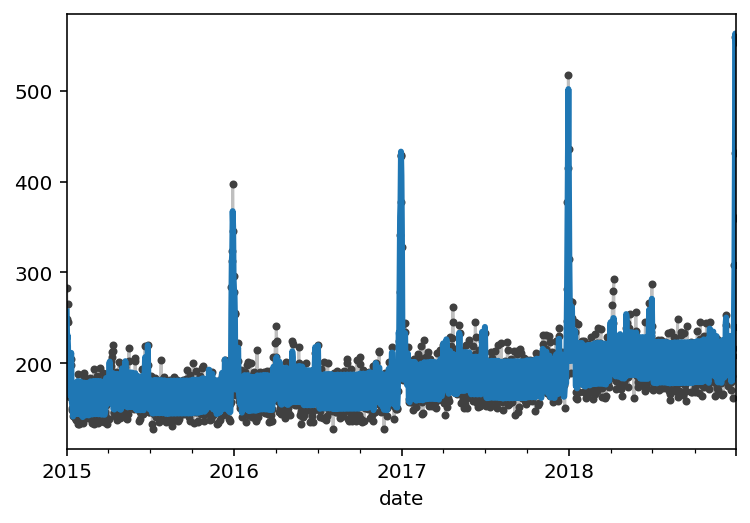

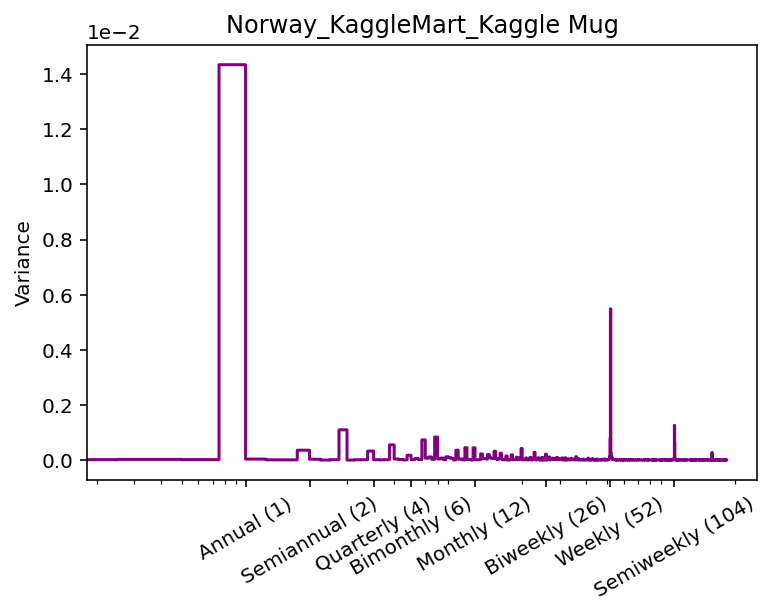

<Figure size 864x576 with 0 Axes>

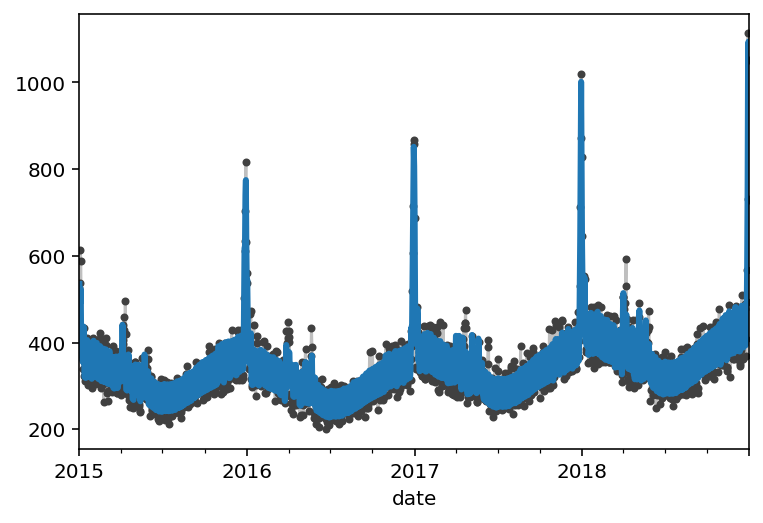

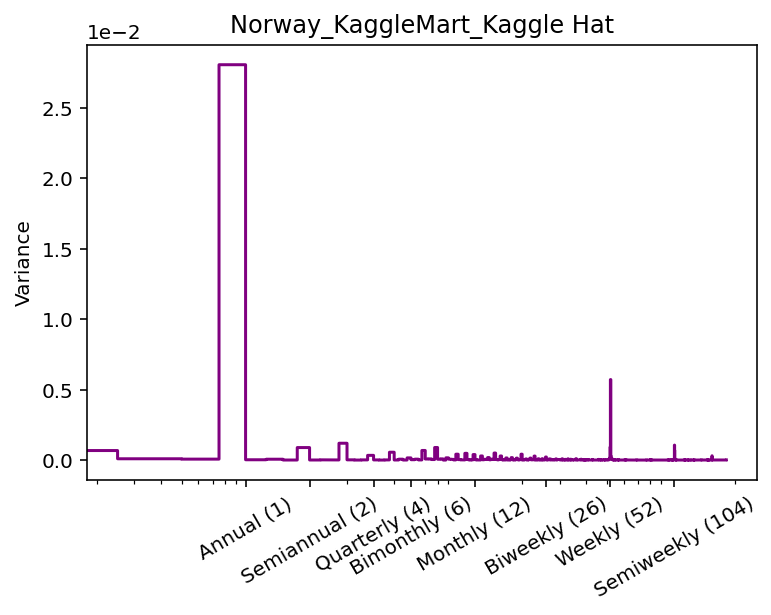

<Figure size 864x576 with 0 Axes>

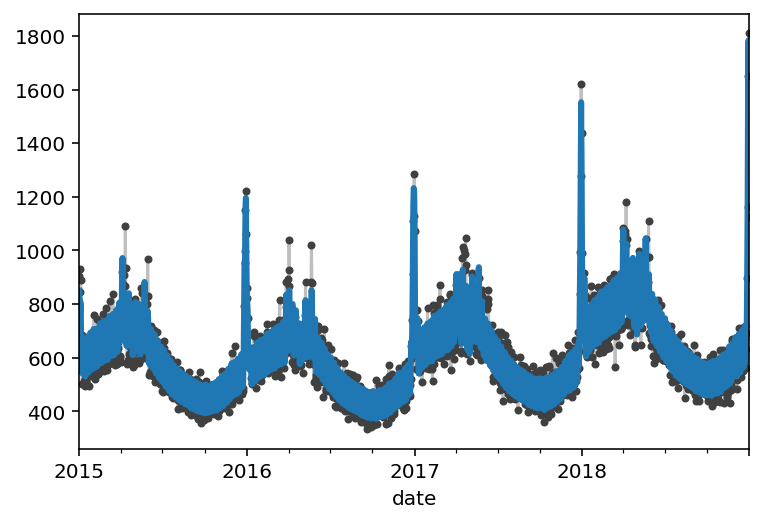

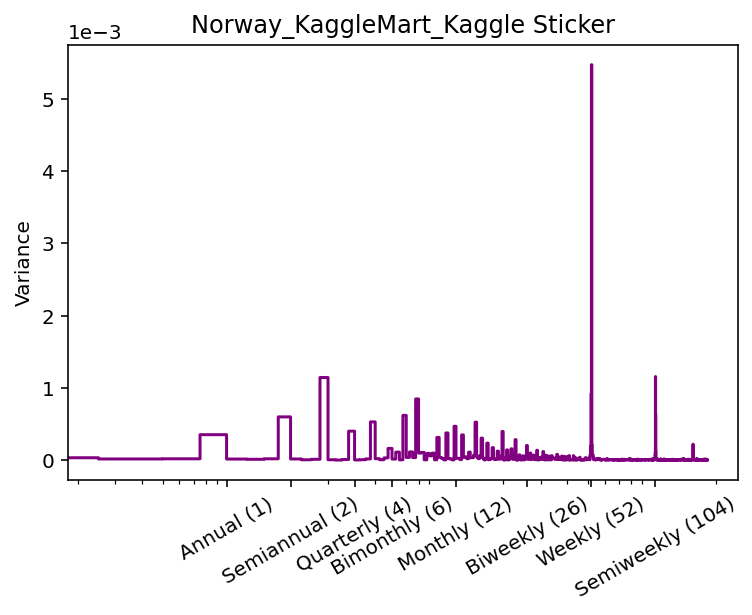

<Figure size 864x576 with 0 Axes>

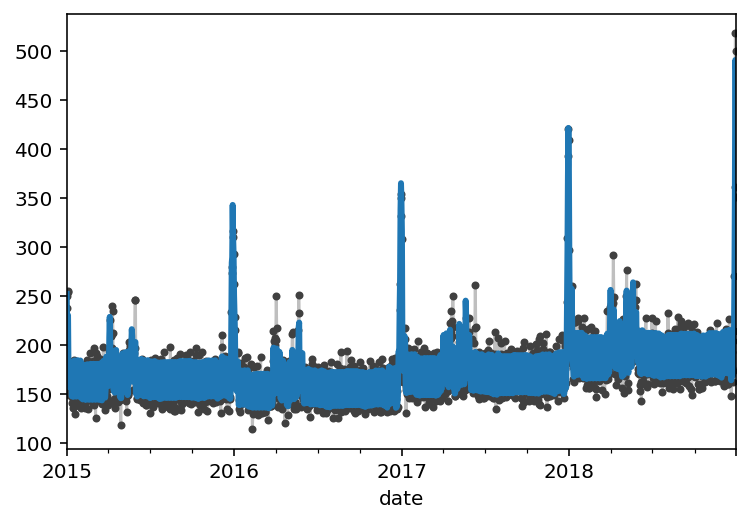

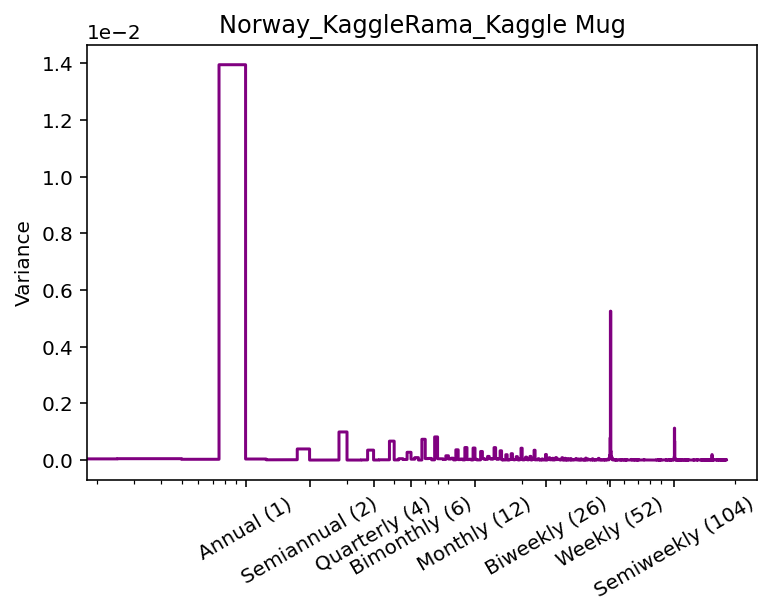

<Figure size 864x576 with 0 Axes>

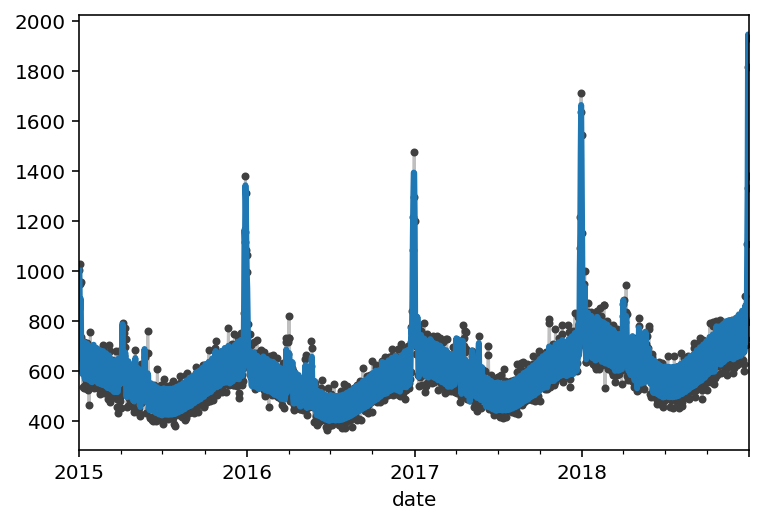

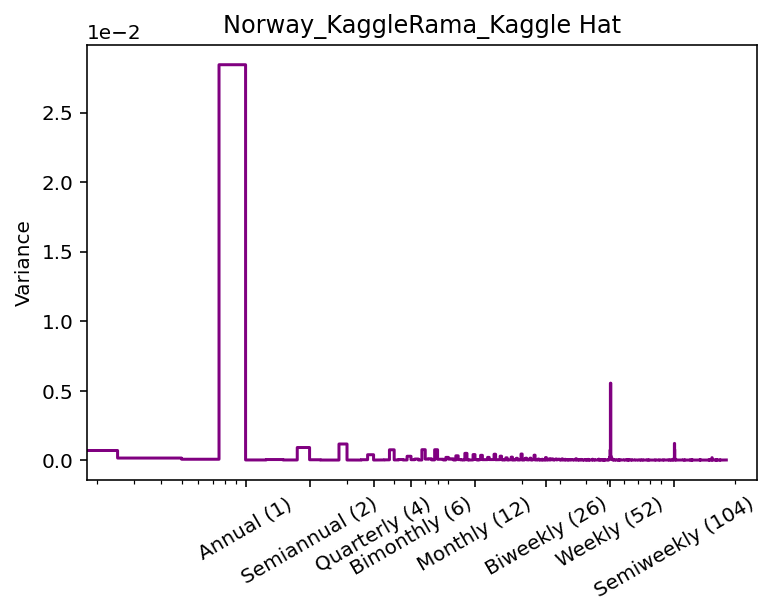

<Figure size 864x576 with 0 Axes>

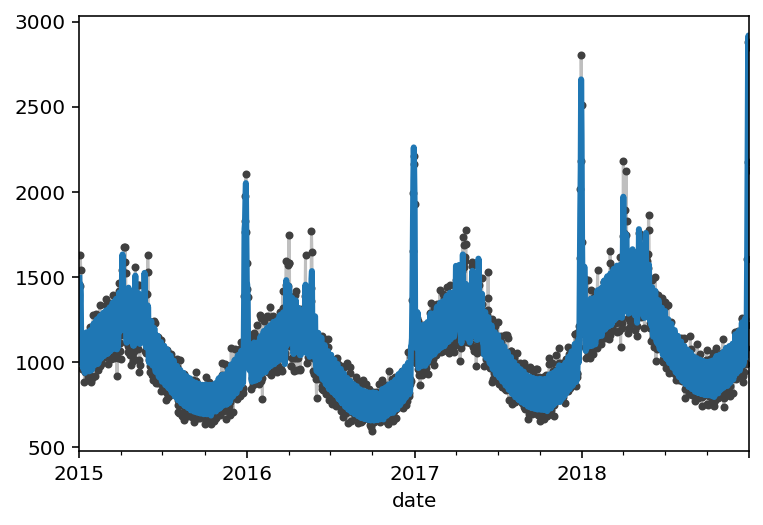

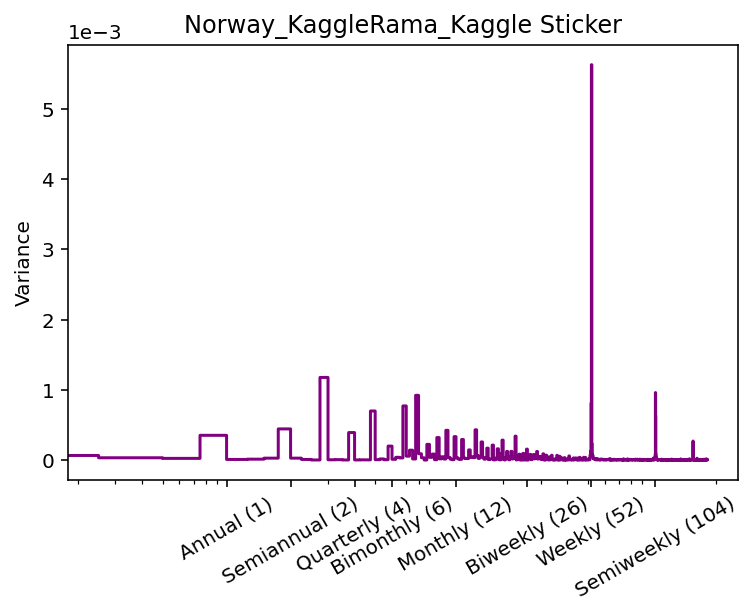

<Figure size 864x576 with 0 Axes>

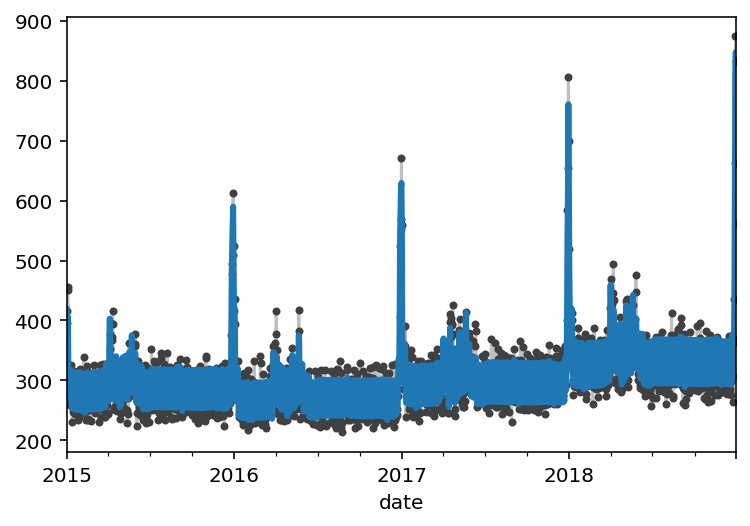

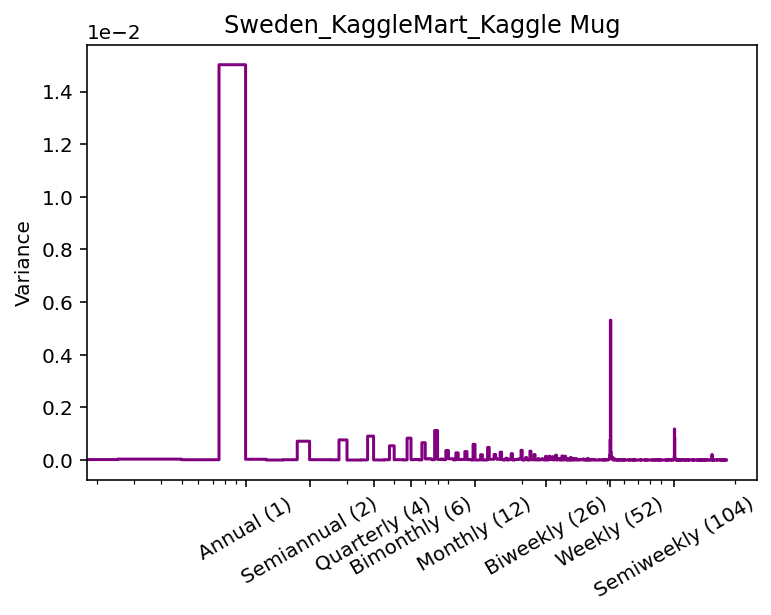

<Figure size 864x576 with 0 Axes>

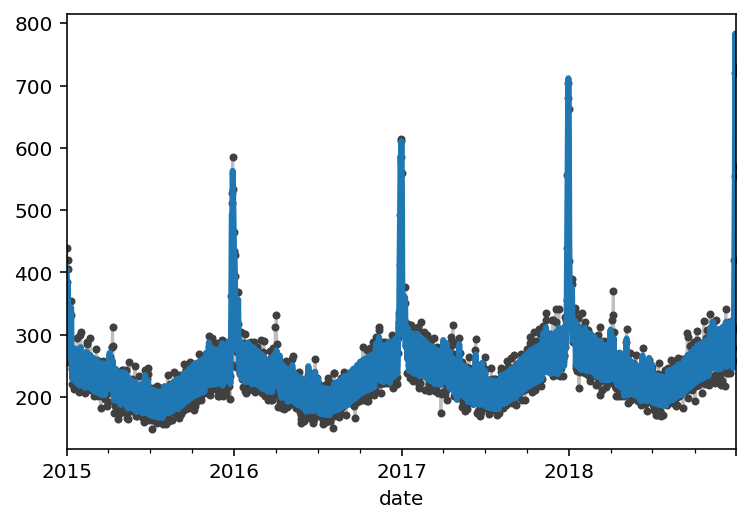

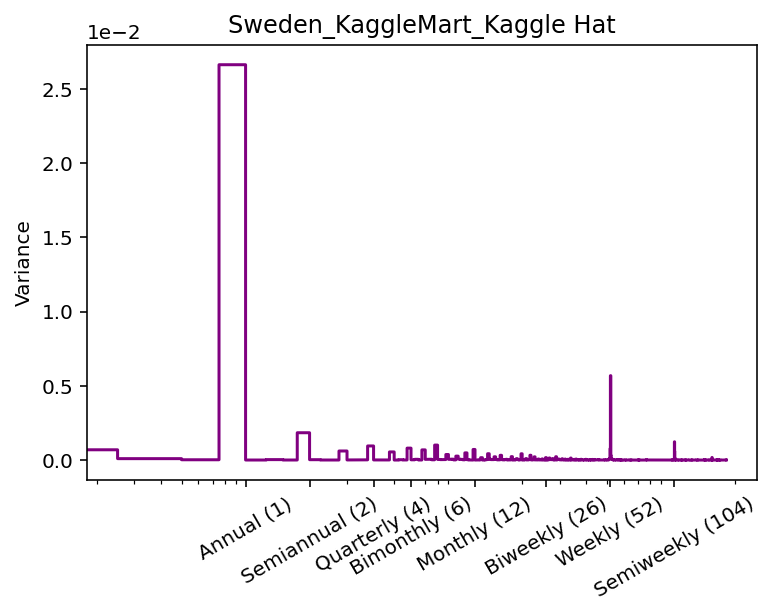

<Figure size 864x576 with 0 Axes>

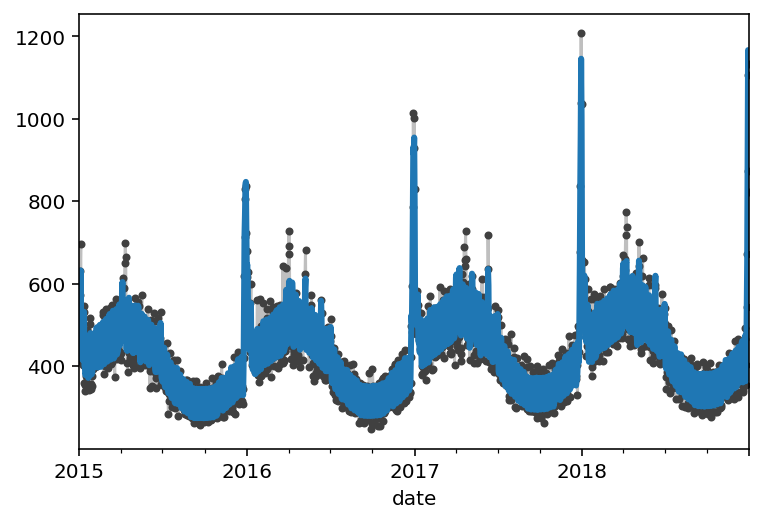

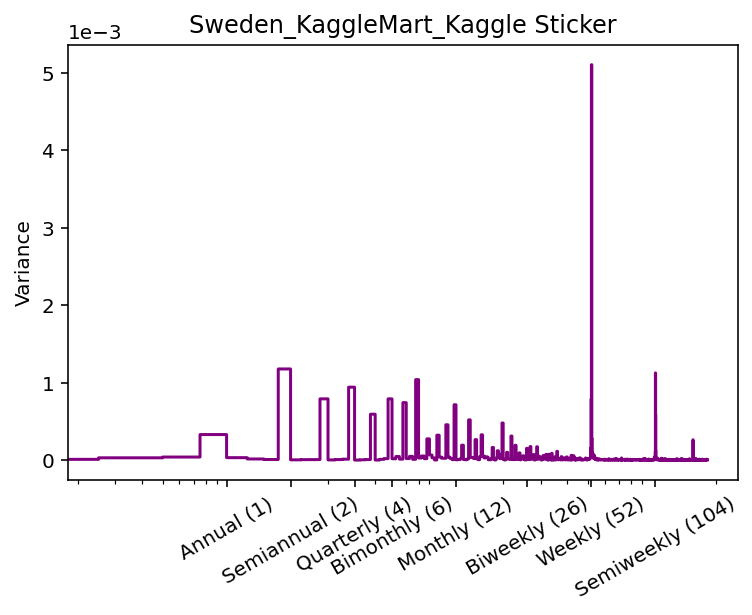

<Figure size 864x576 with 0 Axes>

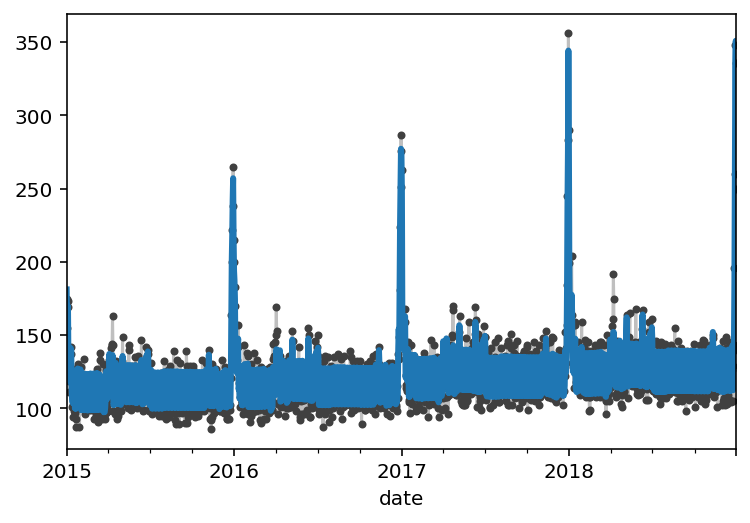

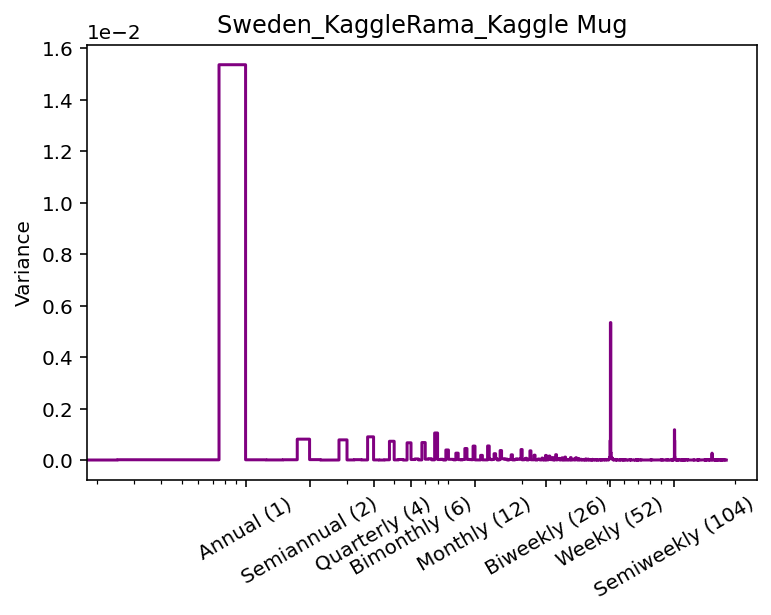

<Figure size 864x576 with 0 Axes>

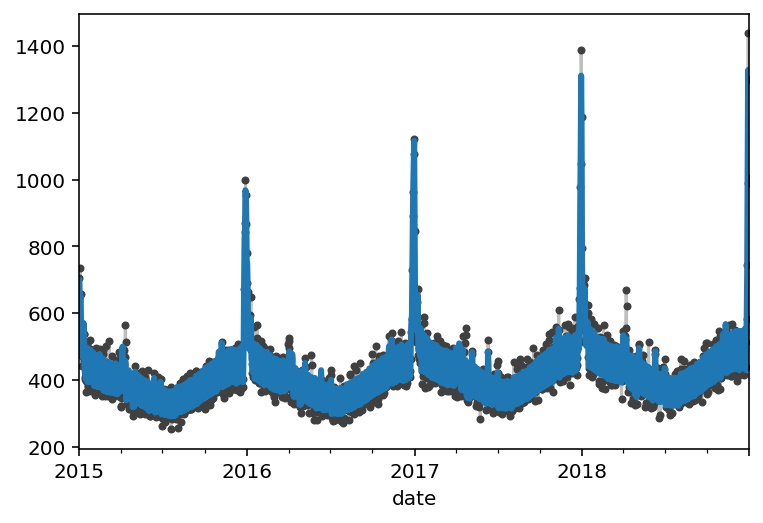

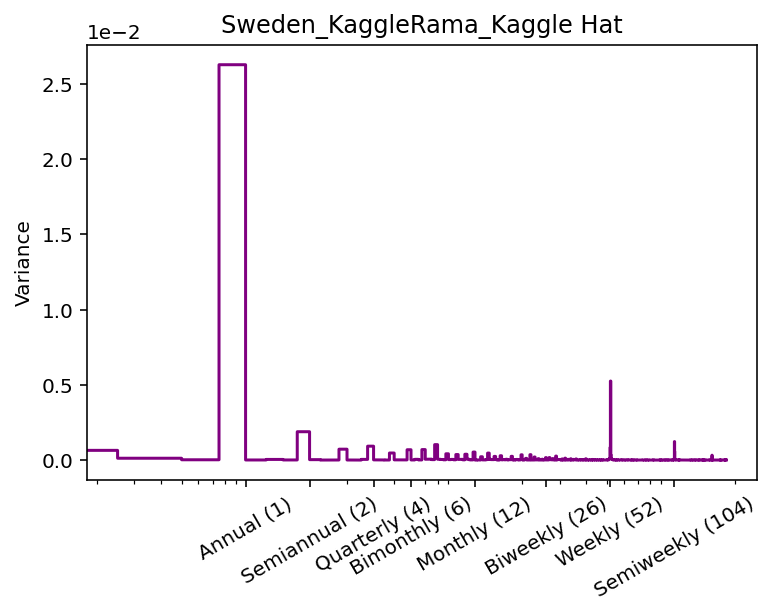

<Figure size 864x576 with 0 Axes>

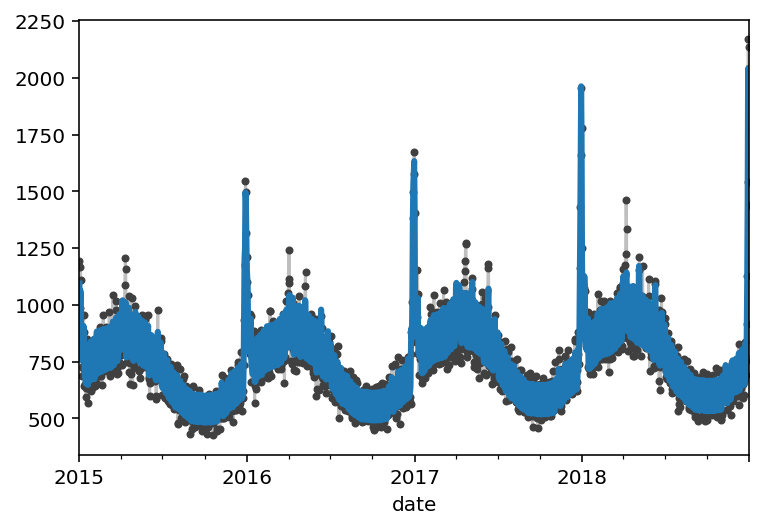

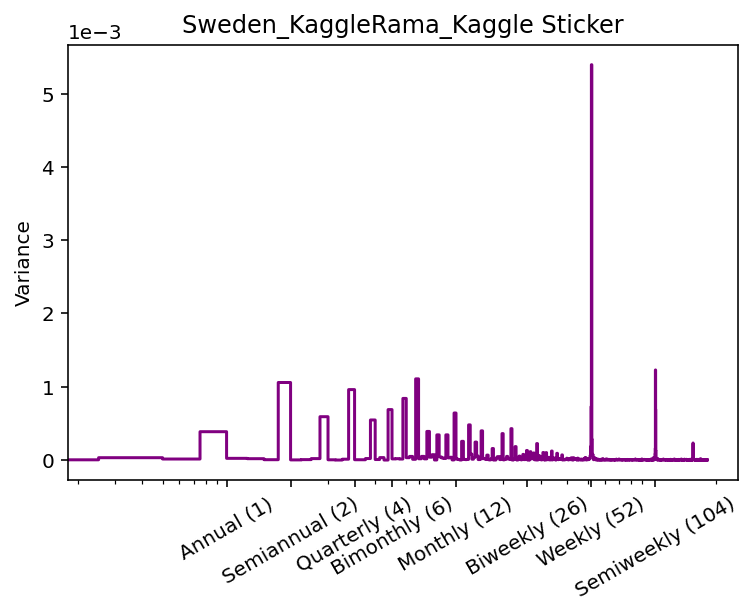

<Figure size 864x576 with 0 Axes>

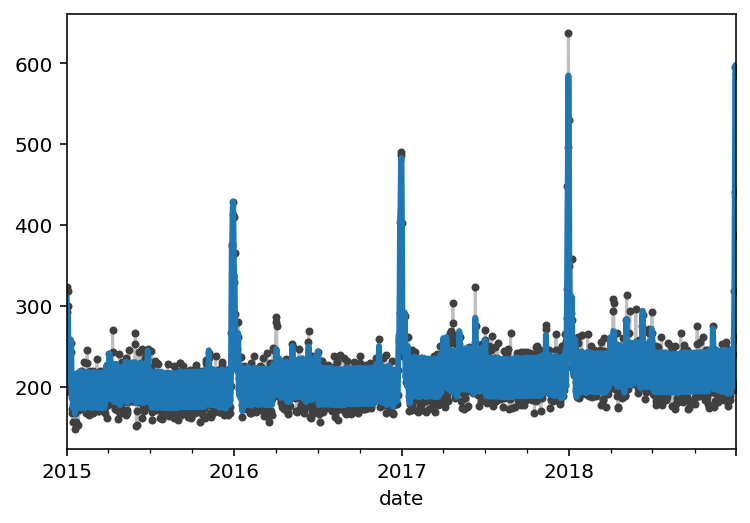

In [11]:
df_predict = pd.DataFrame(columns = ['row_id', 'num_sold'])

#loop to iterate in every combination country/store/product
for country in countrys:
    for store in stores:
        for product in products:            
            sub_train, y = armar_dataset(train, country, store, product)
            sub_train, holidays_names=agregar_holidays(sub_train,country)
            sub_train, lista_fechas=agregar_fechas(sub_train)
            sub_train['gdp']=sub_train.apply(get_gdp, axis=1)
            sub_train['target']=np.log(sub_train['num_sold'] / sub_train['gdp'])
            
            sub_test, _= armar_dataset(test, country, store, product)
            sub_test, holidays_names=agregar_holidays(sub_test,country)
            sub_test, _=agregar_fechas(sub_test)
            sub_test['gdp']=sub_test.apply(get_gdp, axis=1)
            
            rows_ids=np.array(sub_test['row_id'])
            

            df=sub_train
            df=df.reset_index()    
            yy=df.set_index('date').pivot(values='target',columns=['product'])


            X_train=sub_train
            X_val=sub_test
            
            y_train=yy 

            if product=='Kaggle Sticker':
                dp = DeterministicProcess(
                index=y_train.index,
                constant=True,
                order=1,
                seasonal=True,               # weekly seasonality (indicators)
                drop=True,
                )
            else:
                fourier = CalendarFourier(freq="A", order=4) 
                dp = DeterministicProcess(
                index=y_train.index,
                constant=True,
                order=1,
                seasonal=True,               # weekly seasonality (indicators)
                additional_terms=[fourier],  # monthly seasonality (fourier)
                drop=True,
                )

            ax1 = plot_periodogram(y_train[product])
            ax1.set_title(country+'_'+store+'_'+product)

            X1 = dp.in_sample()
            X1_fore = dp.out_of_sample(365,forecast_index=X_val.index)


            #columns_X2=list(holidays_names)+['weekend','day_year']
            columns_X2=list(holidays_names)+['weekend','day_year','month','wednesday']+lista_fechas
            if (country!='Norway'):
                columns_X2.remove('Epiphany')
        
            if (country=='Norway'):
                columns_X2.remove('Pentecost')
                columns_X2.remove('Whit Monday')
            
            X2= np.hstack([X_train[columns_X2]])
            X2_fore=np.hstack([X_val[columns_X2]])
            #print(columns_X2)
            model = BoostedHybrid(
                model_1=LinearRegression(fit_intercept=False),
                #model_1=Ridge(),
                #model_1=Lasso(),
                model_2=XGBRegressor(colsample_bytree = 0.2, learning_rate = 0.1, max_depth = 5, n_estimators = 200),
            )

            model.fit(X1, X2, y_train)
            y_pred = model.predict(X1, X2) #usa el método de la funcion hibrida
            zz=pd.DataFrame(X_train['gdp'])
            rr=np.exp(y_pred)
            y_pred=rr[product]*zz['gdp']

            plt.figure(figsize=(12,8))
            ax = y.plot(**plot_params)
   
            ax=y_pred.plot(ax=ax, linewidth=3, legend=False,);

            y_pred_future = model.predict(X1_fore,X2_fore) #usa el método de la funcion hibrida    
            y_pred_future=np.exp(y_pred_future)*(X_val['gdp'].values[0])#*X_val['gdp']
            
            y_pred_format=np.hstack(np.array((y_pred_future.reset_index()[[product]])))
            df_1=pd.DataFrame({'row_id': rows_ids, 'num_sold': y_pred_format})
            df_predict = pd.concat([df_predict,df_1],axis=0)

In [12]:
df_predict.to_csv('./kaggle_files/modelo_hibrido7.csv',index=False)